# Importing Required Packages & Libraries

In [2]:
# ------------ Deep Learning & Computer Vision ------------
# Core PyTorch for building and training neural networks
import torch
import torch.nn as nn

# Handling pre-trained models and image transformations
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# Tools for data loading and batching
from torch.utils.data import Dataset, DataLoader

# High-speed similarity search for dense vectors
import faiss

# ------------ Data Manipulation & Analysis ---------------
# The standard stack for arrays and dataframes
import numpy as np
import pandas as pd

#  ---------- Machine Learning & Statistics (Scikit-Learn)  ---------------
# Clustering algorithms and evaluation metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality reduction and visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Classifiers and model selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Preprocessing and evaluation performance metrics
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#  ---------- Visualization---------------
# Basic plotting and statistical data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# ----------- File Handling & System Utilities --- ---------------
# OS interaction, file paths, and directory management
import os
import shutil
from pathlib import Path

# Serialization for saving models and config data
import pickle
import json
import yaml

# Compressed file handling and progress bars
import rarfile
from tqdm.notebook import tqdm

# -- ------------ Environment & General Purpose --- ---------------
# Google Colab specific integration
from google.colab import drive

# Image processing (PIL)
from PIL import Image

# Time tracking and memory management
import time
import gc
from datetime import datetime

# Handling warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Create project root in Google Drive
PROJECT_ROOT = '/content/drive/MyDrive/image-clustering-retrieval'
os.makedirs(PROJECT_ROOT, exist_ok=True)

# Create folder structure
folders = [
    'data/raw',
    'data/processed',
    'features',
    'models/pretrained',
    'models/clustering',
    'models/classifier',
    'models/faiss_index',
    'results/clustering',
    'results/retrieval/sample_queries',
    'results/classification',
    'configs'
]

for folder in folders:
    os.makedirs(f'{PROJECT_ROOT}/{folder}', exist_ok=True)

print("✅ Project structure created!")
print(f"📁 Project root: {PROJECT_ROOT}")

# Change working directory
os.chdir(PROJECT_ROOT)
print(f"📂 Current directory: {os.getcwd()}")


Mounted at /content/drive
✅ Project structure created!
📁 Project root: /content/drive/MyDrive/image-clustering-retrieval
📂 Current directory: /content/drive/MyDrive/image-clustering-retrieval


# Install Required Packages

In [1]:
print("📦 Installing required packages...")

!pip install -q torch torchvision
!pip install -q faiss-cpu  # Use faiss-gpu if GPU available
!pip install -q scikit-learn
!pip install -q umap-learn
!pip install -q pillow
!pip install -q matplotlib seaborn
!pip install -q tqdm
!pip install -q pyyaml
!pip install rarfile


print("✅ All packages installed successfully!")


📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 83.0 MB/s eta 0:00:00
✅ All packages installed successfully!


#  Set random seeds

In [4]:
torch.manual_seed(42)
np.random.seed(42)


# Check GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


# Extract Caltech-101 Dataset from RAR (Colab Local Storage)

In [6]:
print("="*60)
print("EXTRACTING CALTECH-101 DATASET FROM RAR (LOCAL COLAB STORAGE)")
print("="*60)

# Install RAR support (only once per runtime)
!apt-get -qq install unrar
!pip install -q rarfile

# Path to uploaded RAR file
uploaded_rar_path = "/content/object.rar"

# Local extraction directory (NOT Google Drive)
extract_dir = "/content"
dataset_path = f"{extract_dir}/object"   # 👈 THIS IS THE KEY FIX

# Check RAR exists
if not os.path.exists(uploaded_rar_path):
    raise FileNotFoundError(
        f"❌ RAR file not found at {uploaded_rar_path}. "
        "Please upload object.rar to Colab."
    )

# Extract only if not already extracted
if not os.path.exists(dataset_path):
    print("📦 Extracting dataset locally in Colab...")

    with rarfile.RarFile(uploaded_rar_path) as rf:
        rf.extractall(extract_dir)

    print("✅ Extraction complete!")
else:
    print("✅ Dataset already extracted — skipping")

# Verify dataset structure
if not os.path.exists(dataset_path):
    raise RuntimeError(
        "❌ Dataset folder 'object/' not found after extraction!"
    )

# Count categories and images
categories = [
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')
]
categories.sort()

total_images = sum(
    len([
        f for f in os.listdir(os.path.join(dataset_path, c))
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    for c in categories
)

print("\n📊 Dataset Statistics:")
print(f"   Total categories: {len(categories)}")
print(f"   Total images: {total_images}")
print(f"\n📁 Dataset location (LOCAL): {dataset_path}")

EXTRACTING CALTECH-101 DATASET FROM RAR (LOCAL COLAB STORAGE)
📦 Extracting dataset locally in Colab...
✅ Extraction complete!

📊 Dataset Statistics:
   Total categories: 51
   Total images: 5163

📁 Dataset location (LOCAL): /content/object


# Create Custom Dataset Class

In [7]:
class ObjectDataset(Dataset):
    """
    Custom Dataset for Caltech-style object dataset
    Folder structure:
    /content/object/
        ├── accordion/
        ├── airplanes/
        ├── ...
    """

    def __init__(self, root_dir="/content/object", transform=None, max_images_per_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_images_per_class = max_images_per_class

        # Get class folders
        self.categories = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}

        self.image_paths = []
        self.labels = []

        print(f"📂 Found {len(self.categories)} categories")

        for category in tqdm(self.categories, desc="Scanning categories"):
            cat_path = os.path.join(root_dir, category)
            cat_idx = self.category_to_idx[category]

            images = [
                f for f in os.listdir(cat_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            if max_images_per_class:
                images = images[:max_images_per_class]

            for img in images:
                self.image_paths.append(os.path.join(cat_path, img))
                self.labels.append(cat_idx)

        print(f"✅ Loaded {len(self.image_paths)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="black")

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_category_name(self, idx):
        return self.categories[idx]


# PHASE 1: DATA PREPARATION"

## Create Dataset and Visualize Samples

------------------------------------------------------------
PHASE 1: DATA PREPARATION
------------------------------------------------------------
📂 Found 51 categories


Scanning categories:   0%|          | 0/51 [00:00<?, ?it/s]

✅ Loaded 5163 images

📊 Dataset created:
   Total images: 5163
   Total categories: 51
✅ Metadata saved

🎨 Visualizing sample images...


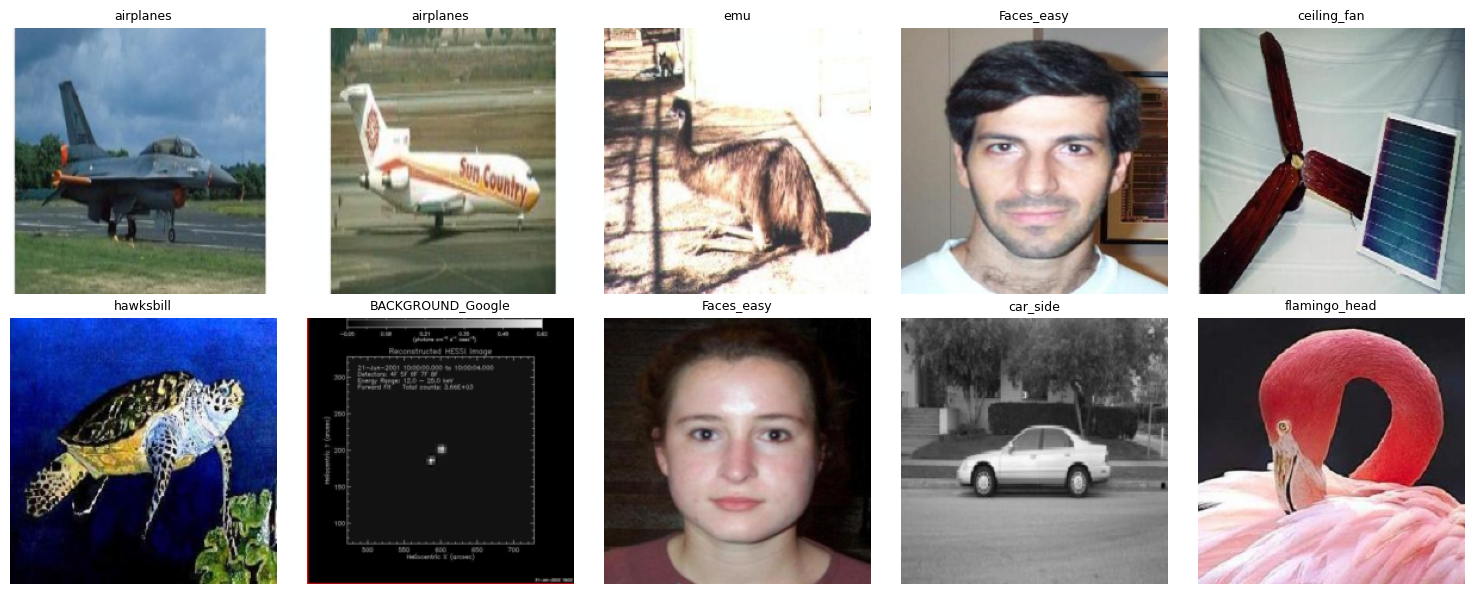

In [8]:
print("-"*60)
print("PHASE 1: DATA PREPARATION")
print("-"*60)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Use CORRECT dataset class
full_dataset = ObjectDataset(
    root_dir=dataset_path,   # /content/object
    transform=transform,
    max_images_per_class=None
)

print(f"\n📊 Dataset created:")
print(f"   Total images: {len(full_dataset)}")
print(f"   Total categories: {len(full_dataset.categories)}")

# Save metadata
metadata = {
    "num_categories": len(full_dataset.categories),
    "num_images": len(full_dataset),
    "categories": full_dataset.categories,
    "category_to_idx": full_dataset.category_to_idx,
    "dataset_path": dataset_path,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

os.makedirs(f"{PROJECT_ROOT}/configs", exist_ok=True)

with open(f"{PROJECT_ROOT}/configs/dataset_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved")

# Visualize samples
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, ax in enumerate(axes):
        img, label = dataset[indices[i]]

        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(dataset.get_category_name(label), fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print("\n🎨 Visualizing sample images...")
visualize_samples(full_dataset)

# PHASE 2: FEATURE EXTRACTION

## Feature Extraction with ResNet-50

In [9]:
print("-"*60)
print("PHASE 2: FEATURE EXTRACTION")
print("-"*60)

class FeatureExtractor:
    def __init__(self, model_name='resnet50', device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_name = model_name

        print(f"\n🔧 Loading pretrained {model_name}...")

        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
            self.feature_dim = 2048
        else:
            raise ValueError("Only resnet50 supported")

        self.model = nn.Sequential(*list(model.children())[:-1])
        self.model.to(self.device)
        self.model.eval()

        print(f"✅ Model loaded on {self.device}")
        print(f"   Feature dimension: {self.feature_dim}")

    def extract_features(self, dataloader, desc="Extracting features"):
        features_list = []
        labels_list = []

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc=desc):
                images = images.to(self.device)

                features = self.model(images)
                features = features.view(features.size(0), -1)

                features_list.append(features.cpu().numpy())
                labels_list.append(labels.numpy())

        features = np.vstack(features_list)
        labels = np.concatenate(labels_list)

        return features, labels
# Dataloader
batch_size = 64
dataloader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Feature extractor
extractor = FeatureExtractor(model_name='resnet50', device=device)

print(f"\n📊 Extracting features from {len(full_dataset)} images...")

features, labels = extractor.extract_features(dataloader)

# Normalize
features_normalized = normalize(features, norm='l2')

# Save
os.makedirs(f"{PROJECT_ROOT}/features", exist_ok=True)

np.save(f"{PROJECT_ROOT}/features/embeddings.npy", features_normalized)
np.save(f"{PROJECT_ROOT}/features/labels.npy", labels)
print("✅ Feature extraction & saving complete!")

------------------------------------------------------------
PHASE 2: FEATURE EXTRACTION
------------------------------------------------------------

🔧 Loading pretrained resnet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


✅ Model loaded on cuda
   Feature dimension: 2048

📊 Extracting features from 5163 images...


Extracting features:   0%|          | 0/81 [00:00<?, ?it/s]

✅ Feature extraction & saving complete!


# PHASE 3: CLUSTERING ANALYSIS
## Find Optimal K using Elbow Method

------------------------------------------------------------
PHASE 3: CLUSTERING ANALYSIS
------------------------------------------------------------

🔍 Finding optimal K (testing K=10 to 100)...


Testing K values:   0%|          | 0/10 [00:00<?, ?it/s]

  K= 10: Inertia=1565.48, Silhouette=0.1339
  K= 20: Inertia=1395.48, Silhouette=0.1092
  K= 30: Inertia=1284.09, Silhouette=0.1049
  K= 40: Inertia=1209.42, Silhouette=0.1178
  K= 50: Inertia=1160.57, Silhouette=0.1211
  K= 60: Inertia=1123.06, Silhouette=0.1130
  K= 70: Inertia=1097.41, Silhouette=0.1121
  K= 80: Inertia=1077.29, Silhouette=0.0996
  K= 90: Inertia=1062.69, Silhouette=0.0843
  K=100: Inertia=1046.84, Silhouette=0.0851


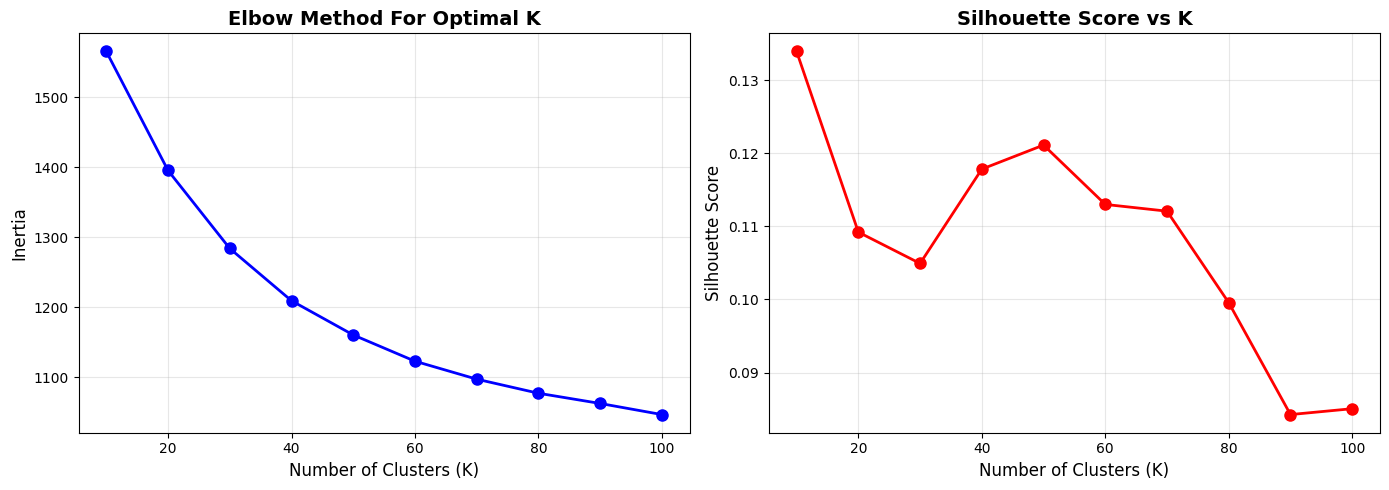


✅ Recommended K: 10 (highest silhouette score)


In [10]:
print("-"*60)
print("PHASE 3: CLUSTERING ANALYSIS")
print("-"*60)

def find_optimal_k(features, k_range=(10, 100), step=10, sample_size=5000):
    """Find optimal K using elbow method"""
    # Sample for faster computation
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_sample = features[indices]
    else:
        features_sample = features

    k_values = list(range(k_range[0], k_range[1] + 1, step))
    inertias = []
    silhouette_scores_list = []

    print(f"\n🔍 Finding optimal K (testing K={k_range[0]} to {k_range[1]})...")

    for k in tqdm(k_values, desc="Testing K values"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(features_sample)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score on smaller sample
        sample_for_sil = min(3000, len(features_sample))
        sil_indices = np.random.choice(len(features_sample), sample_for_sil, replace=False)
        sil_score = silhouette_score(features_sample[sil_indices], labels_pred[sil_indices])
        silhouette_scores_list.append(sil_score)

        print(f"  K={k:3d}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2.plot(k_values, silhouette_scores_list, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{PROJECT_ROOT}/results/clustering/elbow_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Find optimal K
    optimal_k = k_values[np.argmax(silhouette_scores_list)]
    print(f"\n✅ Recommended K: {optimal_k} (highest silhouette score)")

    return k_values, inertias, silhouette_scores_list, optimal_k

# Find optimal K using all features
k_vals, inertias, sil_scores, optimal_k = find_optimal_k(
    features_normalized,
    k_range=(10, 100),
    step=10,
    sample_size=5000)

# Perform K-Means Clustering

In [11]:
def perform_kmeans(features, n_clusters, save_path):
    """Perform K-Means clustering"""
    print(f"\n🔧 Training K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=10,max_iter=300,verbose=1)
    cluster_labels = kmeans.fit_predict(features)

    # Evaluate
    print("\n📊 Evaluating clustering quality...")
    sample_size = min(10000, len(features))
    indices = np.random.choice(len(features), sample_size, replace=False)

    sil_score = silhouette_score(features[indices], cluster_labels[indices])
    db_score = davies_bouldin_score(features, cluster_labels)

    print(f"\n{'-'*60}")
    print("CLUSTERING METRICS")
    print(f"{'-'*60}")
    print(f"Silhouette Score:     {sil_score:.4f}  (higher is better)")
    print(f"Davies-Bouldin Index: {db_score:.4f}  (lower is better)")
    print(f"{'-'*60}")

    # Cluster statistics
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print("\n📈 Cluster Distribution:")
    for cluster_id, count in zip(unique[:10], counts[:10]):
        print(f"  Cluster {cluster_id:3d}: {count:5d} images ({count/len(cluster_labels)*100:.1f}%)")
    if len(unique) > 10:
        print(f"  ... and {len(unique)-10} more clusters")

    # Save model
    with open(f'{save_path}/kmeans_k{n_clusters}.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    # Save cluster labels
    np.save(f'{save_path}/cluster_labels.npy', cluster_labels)

    # Save metrics
    metrics = {
        'n_clusters': n_clusters,
        'silhouette_score': float(sil_score),
        'davies_bouldin_score': float(db_score),
        'cluster_sizes': {int(k): int(v) for k, v in zip(unique, counts)},
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    with open(f'{save_path}/clustering_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"\n✅ K-Means model saved to {save_path}")

    return kmeans, cluster_labels, metrics

# Run clustering on all features
n_clusters = optimal_k
kmeans_model, cluster_labels, clustering_metrics = perform_kmeans(
    features_normalized,
    n_clusters=n_clusters,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)


🔧 Training K-Means with K=10...
Initialization complete
Iteration 0, inertia 2901.978759765625.
Iteration 1, inertia 1689.5599365234375.
Iteration 2, inertia 1655.6884765625.
Iteration 3, inertia 1650.3123779296875.
Iteration 4, inertia 1648.430908203125.
Iteration 5, inertia 1647.4913330078125.
Iteration 6, inertia 1647.1241455078125.
Iteration 7, inertia 1646.916259765625.
Iteration 8, inertia 1646.8055419921875.
Iteration 9, inertia 1646.72705078125.
Iteration 10, inertia 1646.6097412109375.
Iteration 11, inertia 1646.4815673828125.
Iteration 12, inertia 1646.29296875.
Iteration 13, inertia 1646.0545654296875.
Iteration 14, inertia 1645.8294677734375.
Iteration 15, inertia 1645.4296875.
Iteration 16, inertia 1644.52294921875.
Iteration 17, inertia 1642.3289794921875.
Iteration 18, inertia 1639.458251953125.
Iteration 19, inertia 1637.6412353515625.
Iteration 20, inertia 1637.1019287109375.
Iteration 21, inertia 1636.89794921875.
Iteration 22, inertia 1636.788818359375.
Iteration 23

# HIERARCHICAL CLUSTERING (WITH K SELECTION)

🔧 Building linkage matrix (method=average)


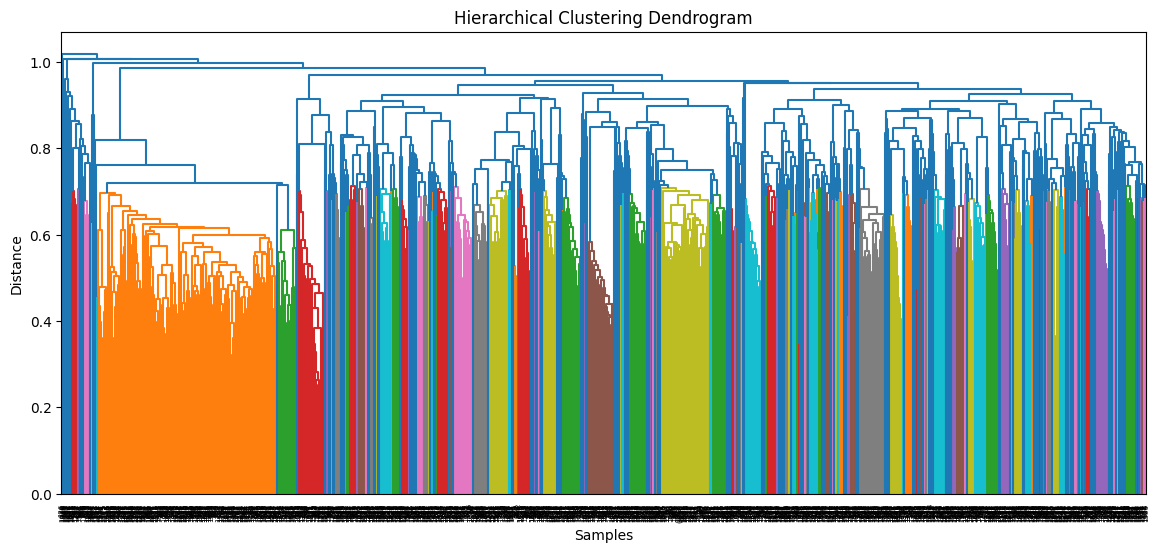

In [12]:
# --------------------------
# STEP 1: Sample Features (Optional)
# --------------------------
def sample_features(features, sample_size=2000, random_state=42):
    if len(features) > sample_size:
        np.random.seed(random_state)
        indices = np.random.choice(len(features), sample_size, replace=False)
        return features[indices], indices
    return features, np.arange(len(features))

# --------------------------
# STEP 2: Build Linkage Matrix
# --------------------------
def build_linkage_matrix(features, method='average'):
    print(f"🔧 Building linkage matrix (method={method})")
    Z = linkage(features, method=method)
    return Z

# --------------------------
# STEP 3: Plot Dendrogram
# --------------------------
def plot_dendrogram(Z, truncate_level=30, max_d=None):
    plt.figure(figsize=(14, 6))
    dendrogram(Z, truncate_mode='level', p=truncate_level)
    if max_d:
        plt.axhline(y=max_d, c='r', linestyle='--')
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

# --------------------------
# STEP 4: Run Dendrogram Analysis
# --------------------------
# Sample features for efficiency
features_sampled, sample_indices = sample_features(features_normalized, sample_size=2000)

# Build linkage
Z = build_linkage_matrix(features_sampled, method='average')

# Plot dendrogram
plot_dendrogram(Z, truncate_level=30)

# Perform Hierarchical Clustering

Using 5000/5163 samples for clustering

FINAL HIERARCHICAL RESULTS
--------------------------------------------------
Linkage:    average
K:          50
Silhouette: 0.1410
DB Index:   2.1691
--------------------------------------------------

✅ HIR model, labels, and metrics saved to /content/drive/MyDrive/image-clustering-retrieval/models/clustering


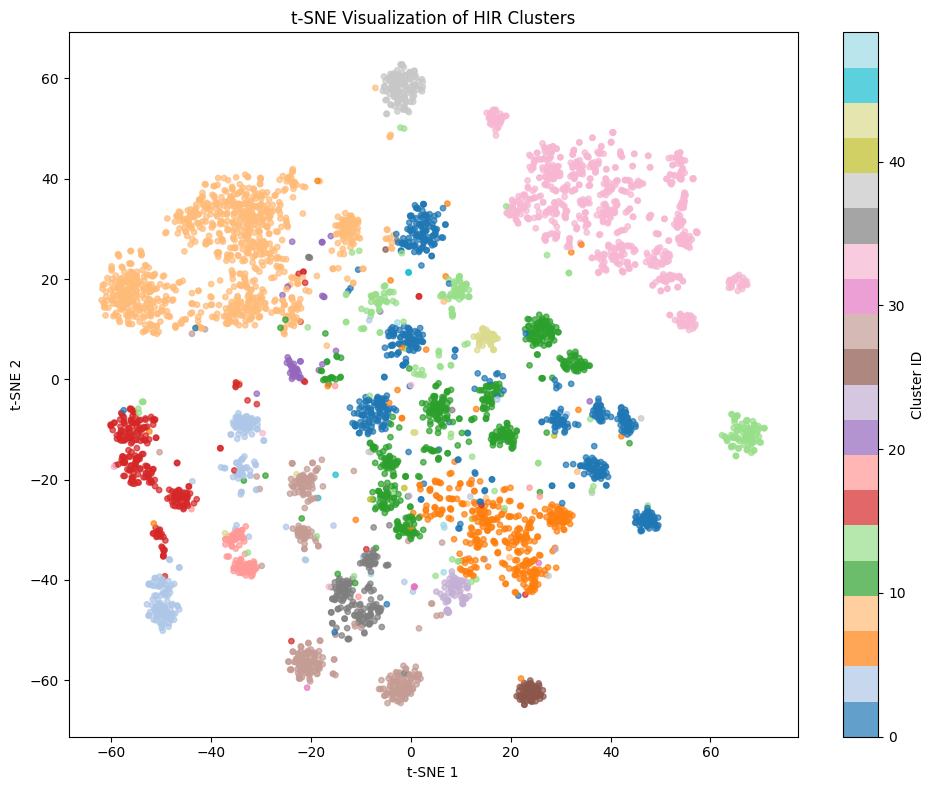

In [13]:


def train_hierarchical_exact_k(features, k=50, linkage_type='average'):
    """
    Train AgglomerativeClustering to produce exactly K clusters
    """
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage=linkage_type
    )
    labels = model.fit_predict(features)

    sil = silhouette_score(features, labels)
    db = davies_bouldin_score(features, labels)

    print("\nFINAL HIERARCHICAL RESULTS")
    print("-" * 50)
    print(f"Linkage:    {linkage_type}")
    print(f"K:          {k}")
    print(f"Silhouette: {sil:.4f}")
    print(f"DB Index:   {db:.4f}")
    print("-" * 50)

    return model, labels, sil, db

# --------------------------
# STEP 2: Full HIR Pipeline (safe sampling)
# --------------------------
def perform_hir_pipeline(features, k=50, linkage_type='average', sample_size=5000, save_path=None):
    """
    Perform HIR clustering with optional sampling, save results.
    Returns cluster labels aligned with features used.
    """
    # 1️⃣ Sample features if needed
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_used = features[indices]
        print(f"Using {len(features_used)}/{len(features)} samples for clustering")
    else:
        indices = np.arange(len(features))
        features_used = features
        print(f"Using all {len(features_used)} samples for clustering")

    # 2️⃣ Train hierarchical clustering
    model, cluster_labels_sample, sil, db = train_hierarchical_exact_k(features_used, k=k, linkage_type=linkage_type)

    # 3️⃣ Save model, labels, and metrics
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/hir_model_k{k}.pkl', 'wb') as f:
            pickle.dump(model, f)
        np.save(f'{save_path}/hir_labels_k{k}.npy', cluster_labels_sample)
        metrics = {
            'k': k,
            'linkage': linkage_type,
            'silhouette_score': float(sil),
            'davies_bouldin_score': float(db),
            'cluster_sizes': {int(c): int(np.sum(cluster_labels_sample==c)) for c in np.unique(cluster_labels_sample)},
            'sample_size': len(features_used),
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(f'{save_path}/hir_metrics_k{k}.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"\n✅ HIR model, labels, and metrics saved to {save_path}")

    return cluster_labels_sample, indices  # return sampled indices too

# --------------------------
# STEP 3: Run HIR
# --------------------------
hir_labels, sampled_indices = perform_hir_pipeline(
    features_normalized,
    k=50,
    linkage_type='average',
    sample_size=5000,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)

# Now use only sampled features for t-SNE to avoid index errors
features_sampled = features_normalized[sampled_indices]
labels_sampled = labels[sampled_indices]

# --------------------------
# STEP 4: t-SNE Visualization
# --------------------------
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(features, labels, cluster_labels, categories, save_path=None):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                          c=cluster_labels, cmap='tab20', s=15, alpha=0.7)
    plt.title("t-SNE Visualization of HIR Clusters")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(scatter, label='Cluster ID')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + '/tsne_hir.png', dpi=300)
    plt.show()

# Call visualization safely
visualize_tsne(
    features=features_sampled,
    labels=labels_sampled,
    cluster_labels=hir_labels,
    categories=full_dataset.categories
)


# Visualize Clusters with t-SNE

Using 5000/5163 samples for clustering

FINAL HIERARCHICAL RESULTS
--------------------------------------------------
Linkage:    average
K:          50
Silhouette: 0.1461
DB Index:   2.1269
--------------------------------------------------

✅ HIR model, labels, and metrics saved to /content/drive/MyDrive/image-clustering-retrieval/models/clustering

🎨 Creating t-SNE visualization...
  Computing t-SNE (this may take a few minutes)...


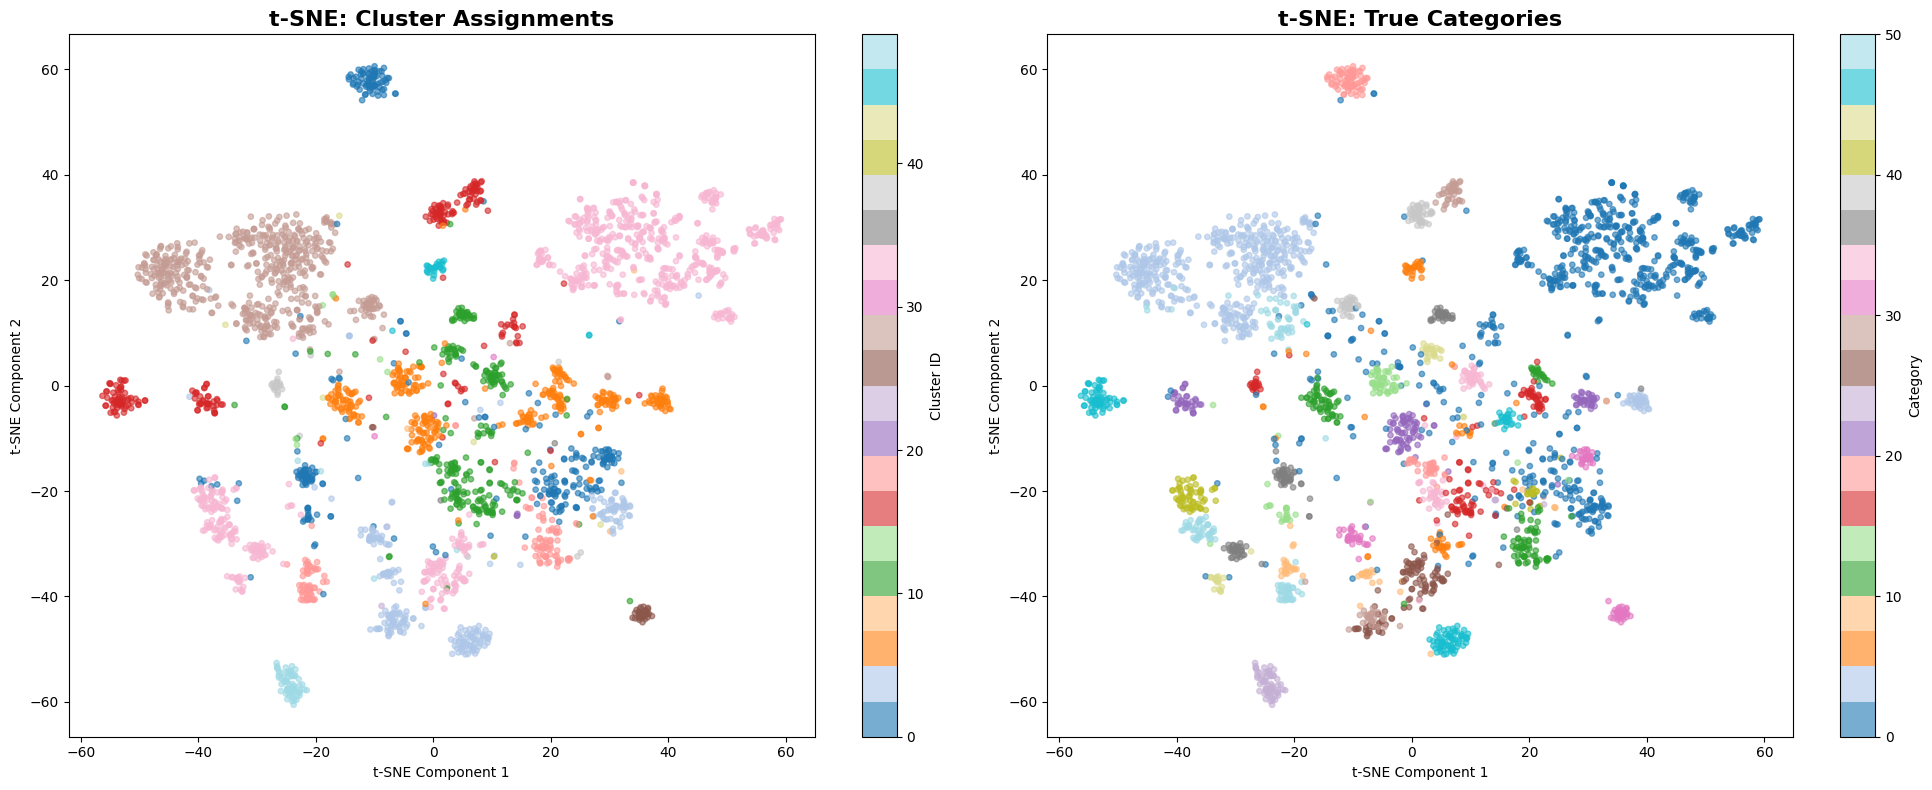

✅ t-SNE visualization complete!


In [14]:

# --------------------------
# STEP 1: Train HIR
# --------------------------
def train_hierarchical_exact_k(features, k=50, linkage_type='average'):
    """Train AgglomerativeClustering to produce exactly K clusters."""
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage=linkage_type
    )
    labels = model.fit_predict(features)

    sil = silhouette_score(features, labels)
    db = davies_bouldin_score(features, labels)

    print("\nFINAL HIERARCHICAL RESULTS")
    print("-" * 50)
    print(f"Linkage:    {linkage_type}")
    print(f"K:          {k}")
    print(f"Silhouette: {sil:.4f}")
    print(f"DB Index:   {db:.4f}")
    print("-" * 50)

    return model, labels, sil, db

# --------------------------
# STEP 2: HIR pipeline (safe sampling)
# --------------------------
def perform_hir_pipeline(features, k=50, linkage_type='average', sample_size=5000, save_path=None):
    """
    Perform hierarchical clustering on a sample of features.
    Returns cluster labels and sampled indices for alignment.
    """
    # 1️⃣ Sample features if needed
    if sample_size and len(features) > sample_size:
        sampled_indices = np.random.choice(len(features), sample_size, replace=False)
        features_used = features[sampled_indices]
        print(f"Using {len(features_used)}/{len(features)} samples for clustering")
    else:
        sampled_indices = np.arange(len(features))
        features_used = features
        print(f"Using all {len(features_used)} samples for clustering")

    # 2️⃣ Train HIR
    model, cluster_labels, sil, db = train_hierarchical_exact_k(features_used, k=k, linkage_type=linkage_type)

    # 3️⃣ Save model, labels, metrics
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/hir_model_k{k}.pkl', 'wb') as f:
            pickle.dump(model, f)
        np.save(f'{save_path}/hir_labels_k{k}.npy', cluster_labels)
        metrics = {
            'k': k,
            'linkage': linkage_type,
            'silhouette_score': float(sil),
            'davies_bouldin_score': float(db),
            'cluster_sizes': {int(c): int(np.sum(cluster_labels==c)) for c in np.unique(cluster_labels)},
            'sample_size': len(features_used),
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(f'{save_path}/hir_metrics_k{k}.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"\n✅ HIR model, labels, and metrics saved to {save_path}")

    return cluster_labels, sampled_indices

# --------------------------
# STEP 3: t-SNE visualization
# --------------------------
def visualize_tsne(features, labels, cluster_labels, categories=None, sample_size=3000, save_path=None):
    """
    Create t-SNE visualization for hierarchical clusters and true labels.
    """
    print("\n🎨 Creating t-SNE visualization...")

    # Safe sampling
    n_samples = min(sample_size, len(features))
    indices = np.random.choice(len(features), n_samples, replace=False)
    features_sample = features[indices]
    labels_sample = labels[indices]
    cluster_sample = cluster_labels[indices]

    # t-SNE projection
    print("  Computing t-SNE (this may take a few minutes)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
    features_2d = tsne.fit_transform(features_sample)

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Cluster assignments
    scatter1 = ax1.scatter(features_2d[:,0], features_2d[:,1],
                           c=cluster_sample, cmap='tab20', s=15, alpha=0.6)
    ax1.set_title('t-SNE: Cluster Assignments', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

    # True labels
    scatter2 = ax2.scatter(features_2d[:,0], features_2d[:,1],
                           c=labels_sample, cmap='tab20', s=15, alpha=0.6)
    ax2.set_title('t-SNE: True Categories', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter2, ax=ax2, label='Category')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print("✅ t-SNE visualization complete!")

# --------------------------
# STEP 4: Run HIR + t-SNE
# --------------------------
hir_labels, sampled_indices = perform_hir_pipeline(
    features=features_normalized,
    k=50,
    linkage_type='average',
    sample_size=5000,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)

# Use sampled features and labels for t-SNE
features_sampled = features_normalized[sampled_indices]
labels_sampled = labels[sampled_indices]

visualize_tsne(
    features=features_sampled,
    labels=labels_sampled,
    cluster_labels=hir_labels,
    categories=None,
    sample_size=3000,
    save_path=f'{PROJECT_ROOT}/results/clustering/tsne_plot.png'
)


# Analyze Cluster Composition

Using 5000/5163 samples for clustering

FINAL HIERARCHICAL RESULTS
--------------------------------------------------
Linkage:    average
K:          50
Silhouette: 0.1409
DB Index:   2.2168
--------------------------------------------------

✅ HIR model, labels, and metrics saved to /content/drive/MyDrive/image-clustering-retrieval/models/clustering

🎨 Creating t-SNE visualization...
  Computing t-SNE (this may take a few minutes)...


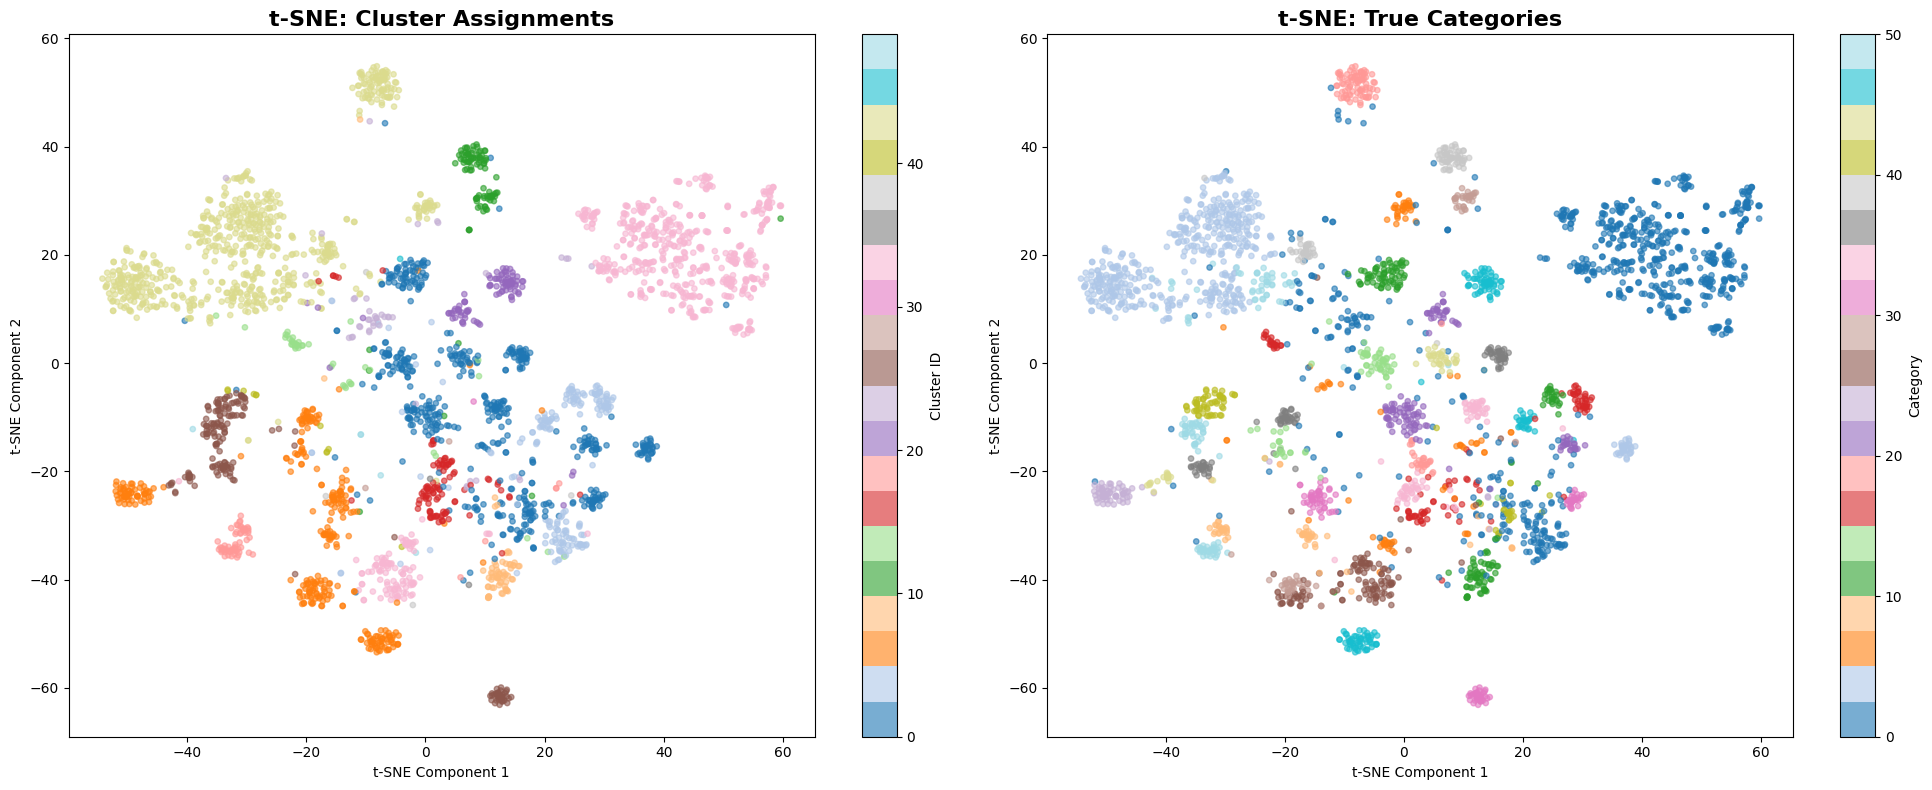

✅ t-SNE visualization complete!

📊 Analyzing HIR cluster composition...

Cluster 0 (325 images, entropy=2.22):
  • bonsai: 114 (35.1%)
  • chandelier: 96 (29.5%)
  • buddha: 79 (24.3%)
  • BACKGROUND_Google: 15 (4.6%)
  • butterfly: 3 (0.9%)


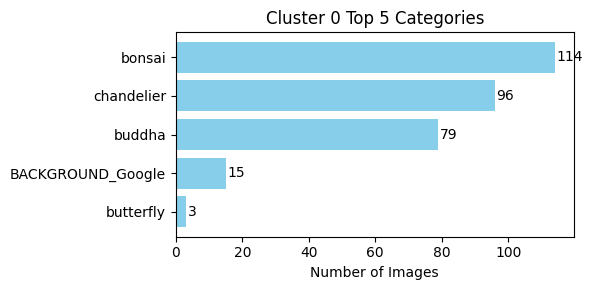


Cluster 1 (197 images, entropy=2.70):
  • BACKGROUND_Google: 76 (38.6%)
  • dollar_bill: 50 (25.4%)
  • garfield: 30 (15.2%)
  • bass: 8 (4.1%)
  • brain: 5 (2.5%)


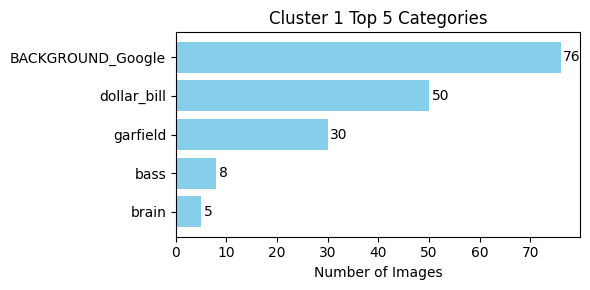


Cluster 2 (368 images, entropy=3.26):
  • electric_guitar: 69 (18.8%)
  • euphonium: 62 (16.8%)
  • cellphone: 57 (15.5%)
  • accordion: 54 (14.7%)
  • gramophone: 42 (11.4%)


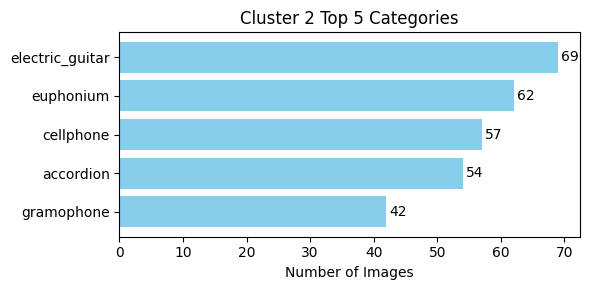


Cluster 3 (135 images, entropy=0.69):
  • BACKGROUND_Google: 124 (91.9%)
  • helicopter: 1 (0.7%)
  • garfield: 1 (0.7%)
  • grand_piano: 1 (0.7%)
  • electric_guitar: 1 (0.7%)


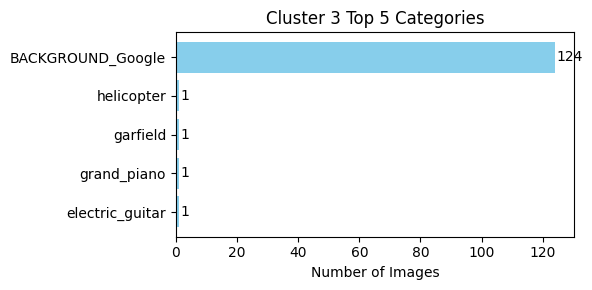


Cluster 4 (142 images, entropy=2.43):
  • camera: 47 (33.1%)
  • headphone: 39 (27.5%)
  • binocular: 32 (22.5%)
  • BACKGROUND_Google: 10 (7.0%)
  • cup: 2 (1.4%)


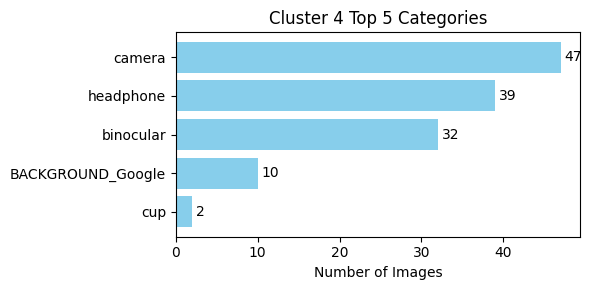


Cluster 5 (296 images, entropy=2.46):
  • hawksbill: 97 (32.8%)
  • dolphin: 61 (20.6%)
  • crocodile_head: 46 (15.5%)
  • crocodile: 45 (15.2%)
  • bass: 37 (12.5%)


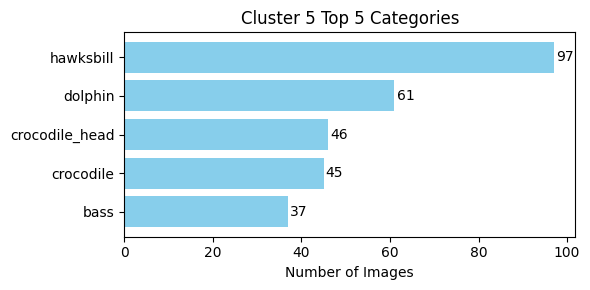


Cluster 6 (2 images, entropy=-0.00):
  • BACKGROUND_Google: 2 (100.0%)


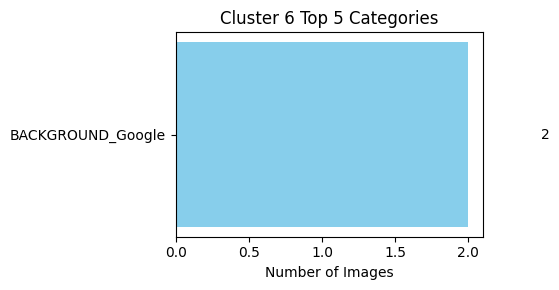


Cluster 7 (205 images, entropy=2.43):
  • elephant: 60 (29.3%)
  • cougar_face: 59 (28.8%)
  • cougar_body: 45 (22.0%)
  • brontosaurus: 23 (11.2%)
  • beaver: 6 (2.9%)


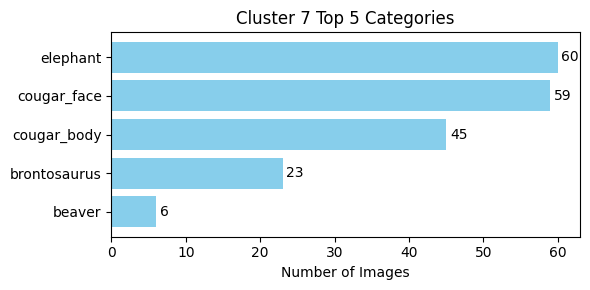


Cluster 8 (5 images, entropy=-0.00):
  • BACKGROUND_Google: 5 (100.0%)


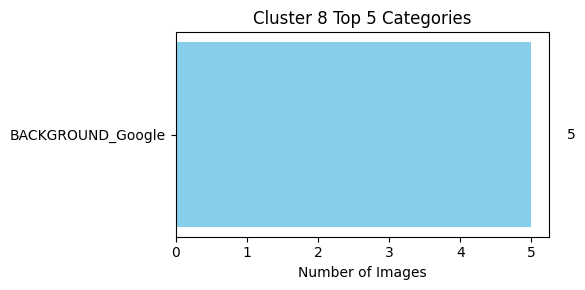


Cluster 9 (103 images, entropy=0.70):
  • brain: 91 (88.3%)
  • BACKGROUND_Google: 8 (7.8%)
  • crab: 1 (1.0%)
  • elephant: 1 (1.0%)
  • barrel: 1 (1.0%)


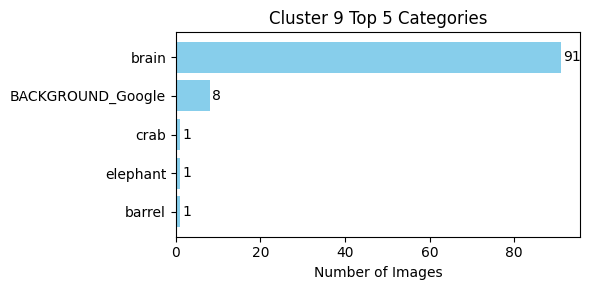


Cluster 10 (9 images, entropy=1.45):
  • BACKGROUND_Google: 6 (66.7%)
  • bass: 1 (11.1%)
  • Faces_easy: 1 (11.1%)
  • Faces: 1 (11.1%)


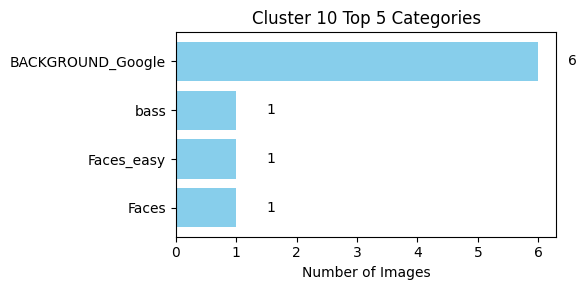


Cluster 11 (138 images, entropy=1.27):
  • ewer: 81 (58.7%)
  • cup: 49 (35.5%)
  • BACKGROUND_Google: 6 (4.3%)
  • chandelier: 2 (1.4%)


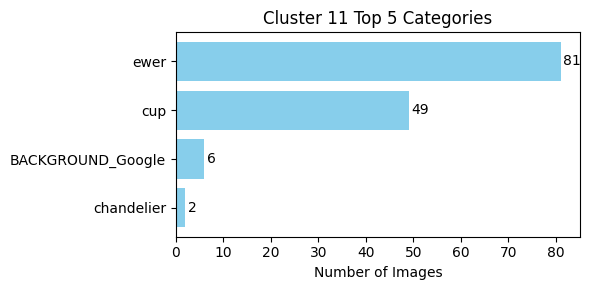


Cluster 12 (3 images, entropy=-0.00):
  • BACKGROUND_Google: 3 (100.0%)


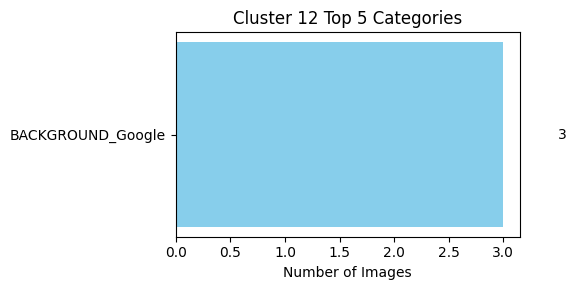


Cluster 13 (6 images, entropy=-0.00):
  • BACKGROUND_Google: 6 (100.0%)


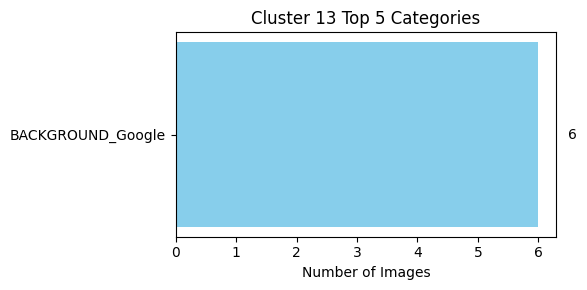


Cluster 14 (64 images, entropy=1.99):
  • cannon: 35 (54.7%)
  • anchor: 15 (23.4%)
  • BACKGROUND_Google: 5 (7.8%)
  • electric_guitar: 3 (4.7%)
  • ceiling_fan: 2 (3.1%)


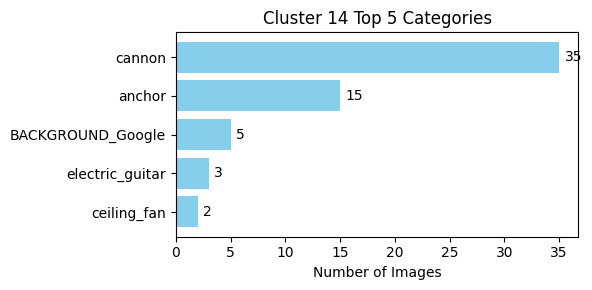


Cluster 15 (162 images, entropy=1.87):
  • butterfly: 66 (40.7%)
  • dragonfly: 48 (29.6%)
  • ceiling_fan: 40 (24.7%)
  • cougar_face: 3 (1.9%)
  • BACKGROUND_Google: 2 (1.2%)


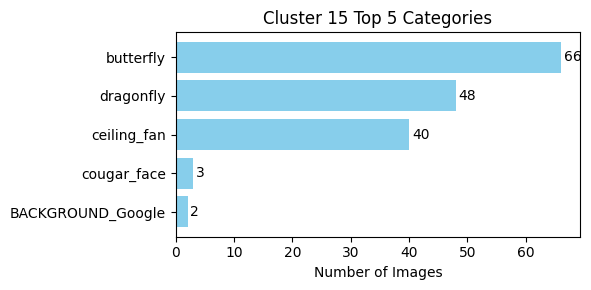


Cluster 16 (3 images, entropy=0.92):
  • BACKGROUND_Google: 2 (66.7%)
  • dolphin: 1 (33.3%)


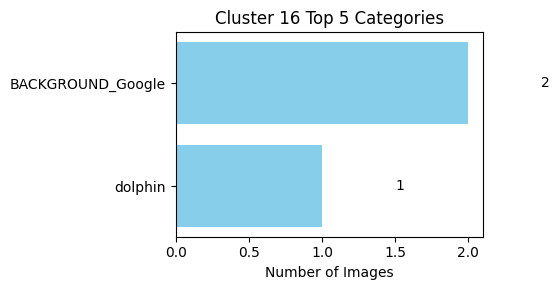


Cluster 17 (6 images, entropy=1.25):
  • BACKGROUND_Google: 4 (66.7%)
  • crocodile: 1 (16.7%)
  • bonsai: 1 (16.7%)


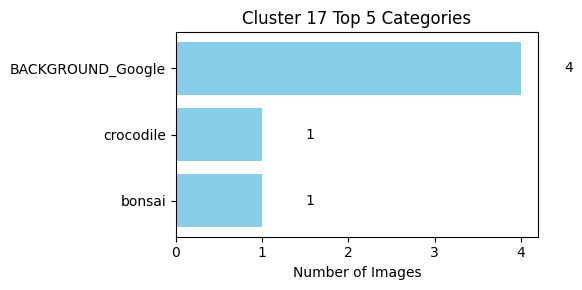


Cluster 18 (7 images, entropy=0.59):
  • BACKGROUND_Google: 6 (85.7%)
  • bonsai: 1 (14.3%)


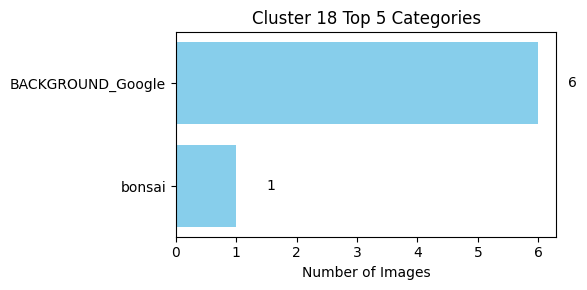


Cluster 19 (88 images, entropy=1.24):
  • hedgehog: 49 (55.7%)
  • beaver: 35 (39.8%)
  • BACKGROUND_Google: 3 (3.4%)
  • crocodile_head: 1 (1.1%)


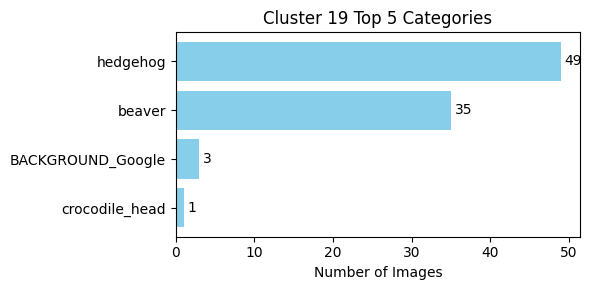


Cluster 20 (4 images, entropy=-0.00):
  • BACKGROUND_Google: 4 (100.0%)


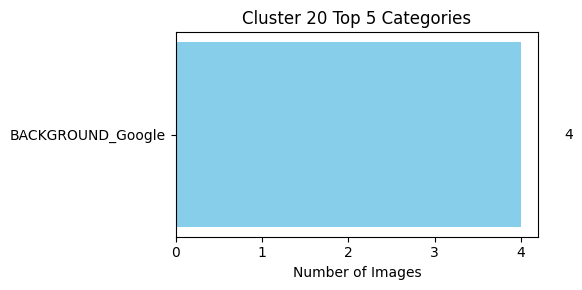


Cluster 21 (151 images, entropy=1.13):
  • grand_piano: 95 (62.9%)
  • chair: 52 (34.4%)
  • BACKGROUND_Google: 2 (1.3%)
  • euphonium: 1 (0.7%)
  • ceiling_fan: 1 (0.7%)


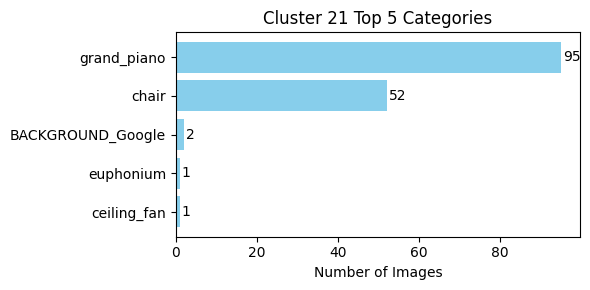


Cluster 22 (7 images, entropy=-0.00):
  • BACKGROUND_Google: 7 (100.0%)


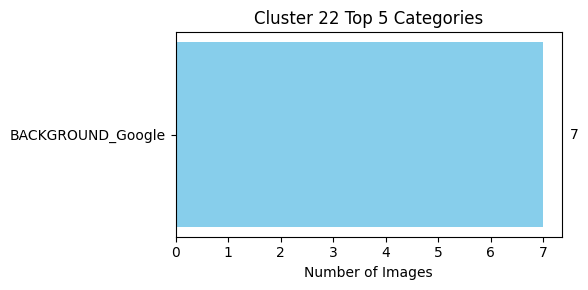


Cluster 23 (9 images, entropy=2.06):
  • butterfly: 4 (44.4%)
  • BACKGROUND_Google: 2 (22.2%)
  • crab: 1 (11.1%)
  • chandelier: 1 (11.1%)
  • ant: 1 (11.1%)


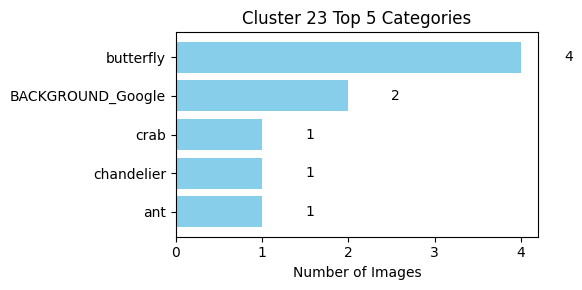


Cluster 24 (60 images, entropy=0.57):
  • BACKGROUND_Google: 55 (91.7%)
  • barrel: 2 (3.3%)
  • helicopter: 1 (1.7%)
  • ferry: 1 (1.7%)
  • grand_piano: 1 (1.7%)


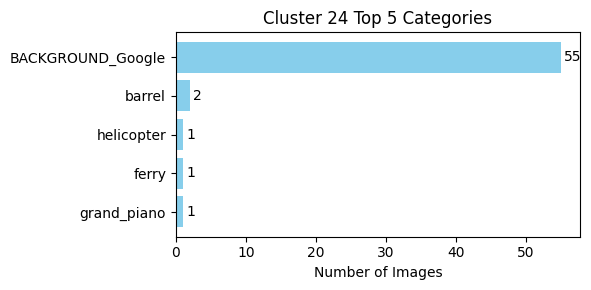


Cluster 25 (64 images, entropy=-0.00):
  • dalmatian: 64 (100.0%)


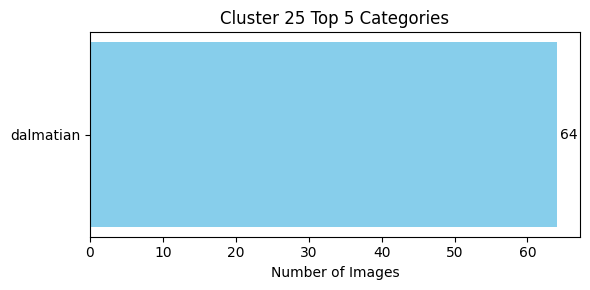


Cluster 26 (270 images, entropy=2.53):
  • ibis: 77 (28.5%)
  • flamingo: 60 (22.2%)
  • emu: 51 (18.9%)
  • flamingo_head: 36 (13.3%)
  • gerenuk: 31 (11.5%)


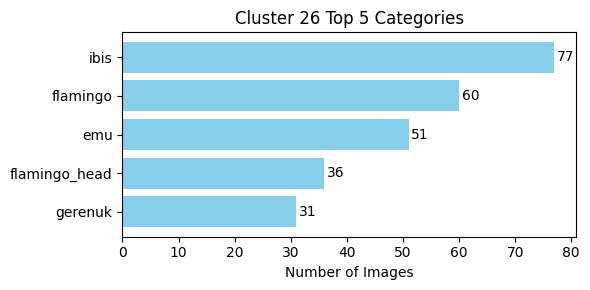


Cluster 27 (1 images, entropy=-0.00):
  • BACKGROUND_Google: 1 (100.0%)


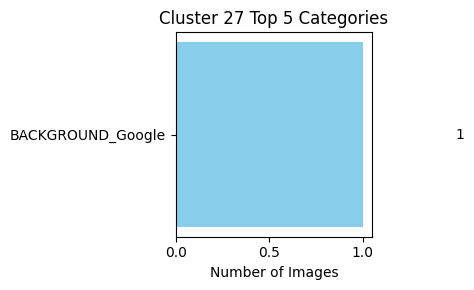


Cluster 28 (2 images, entropy=1.00):
  • airplanes: 1 (50.0%)
  • BACKGROUND_Google: 1 (50.0%)


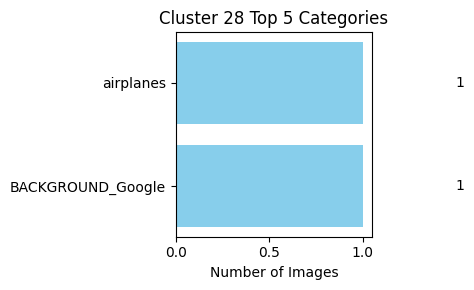


Cluster 29 (2 images, entropy=-0.00):
  • BACKGROUND_Google: 2 (100.0%)


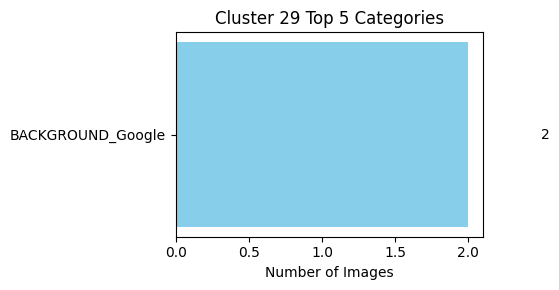


Cluster 30 (2 images, entropy=-0.00):
  • BACKGROUND_Google: 2 (100.0%)


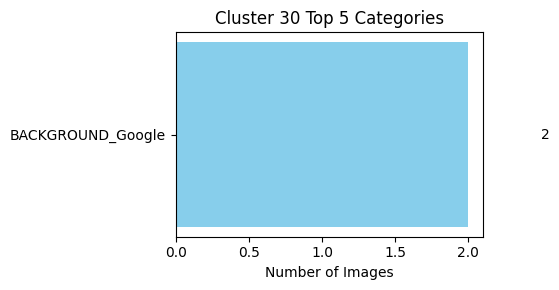


Cluster 31 (1 images, entropy=-0.00):
  • BACKGROUND_Google: 1 (100.0%)


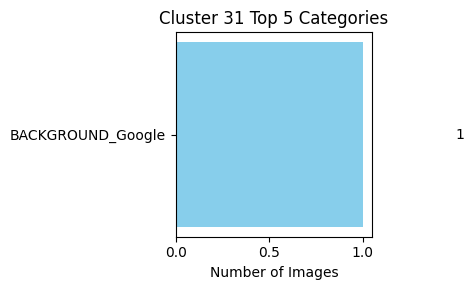


Cluster 32 (830 images, entropy=1.00):
  • Faces: 417 (50.2%)
  • Faces_easy: 413 (49.8%)


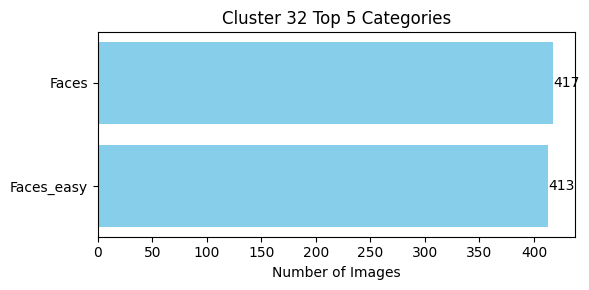


Cluster 33 (171 images, entropy=1.91):
  • crab: 67 (39.2%)
  • crayfish: 63 (36.8%)
  • ant: 30 (17.5%)
  • BACKGROUND_Google: 3 (1.8%)
  • bass: 3 (1.8%)


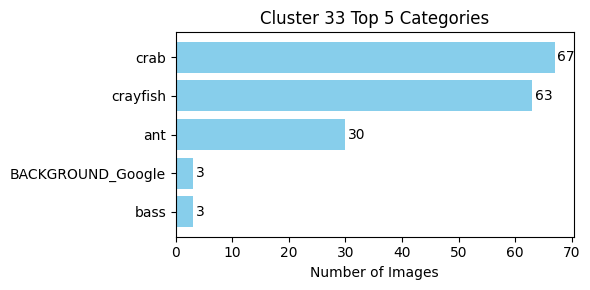


Cluster 34 (7 images, entropy=0.99):
  • bonsai: 4 (57.1%)
  • BACKGROUND_Google: 3 (42.9%)


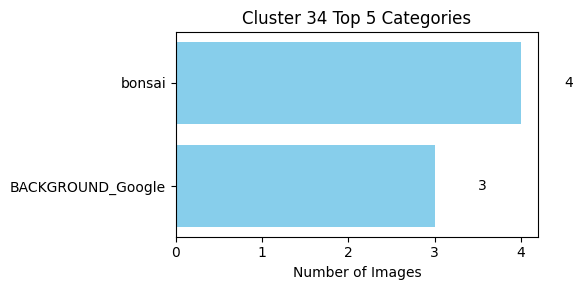


Cluster 35 (2 images, entropy=1.00):
  • butterfly: 1 (50.0%)
  • BACKGROUND_Google: 1 (50.0%)


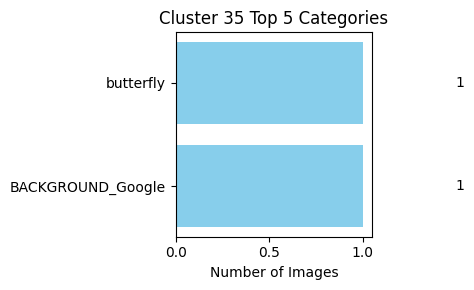


Cluster 36 (4 images, entropy=-0.00):
  • BACKGROUND_Google: 4 (100.0%)


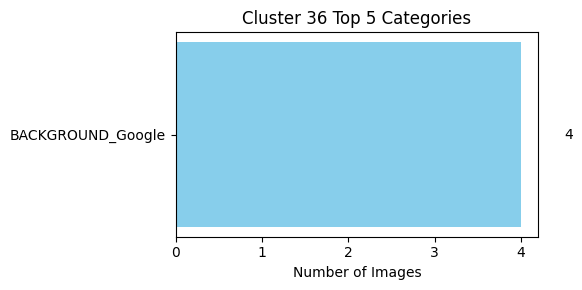


Cluster 37 (2 images, entropy=1.00):
  • dolphin: 1 (50.0%)
  • beaver: 1 (50.0%)


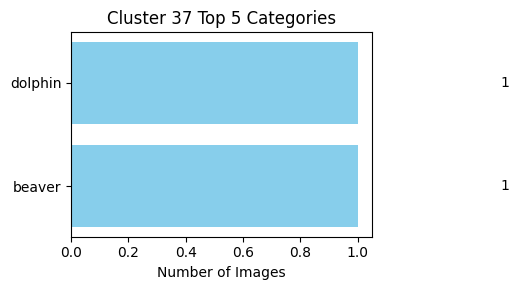


Cluster 38 (3 images, entropy=1.58):
  • garfield: 1 (33.3%)
  • crayfish: 1 (33.3%)
  • BACKGROUND_Google: 1 (33.3%)


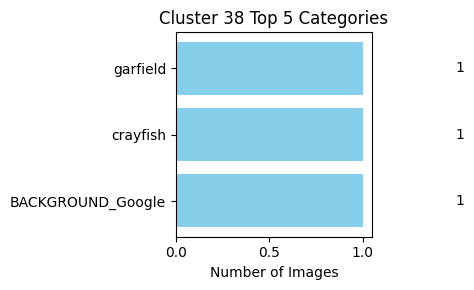


Cluster 39 (1 images, entropy=-0.00):
  • BACKGROUND_Google: 1 (100.0%)


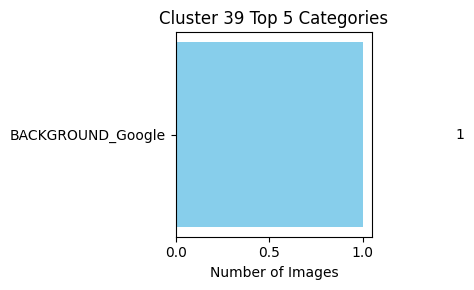


Cluster 40 (10 images, entropy=1.96):
  • flamingo_head: 5 (50.0%)
  • brontosaurus: 2 (20.0%)
  • flamingo: 1 (10.0%)
  • crab: 1 (10.0%)
  • BACKGROUND_Google: 1 (10.0%)


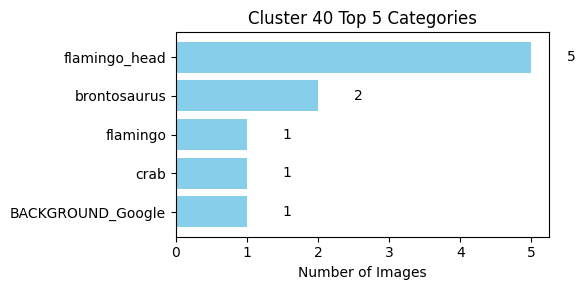


Cluster 41 (5 images, entropy=1.52):
  • ant: 2 (40.0%)
  • BACKGROUND_Google: 2 (40.0%)
  • crayfish: 1 (20.0%)


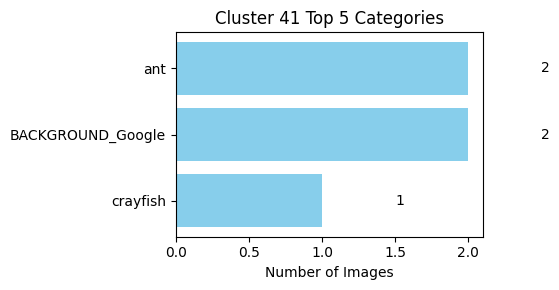


Cluster 42 (927 images, entropy=0.91):
  • airplanes: 770 (83.1%)
  • helicopter: 80 (8.6%)
  • ferry: 61 (6.6%)
  • BACKGROUND_Google: 11 (1.2%)
  • ant: 2 (0.2%)


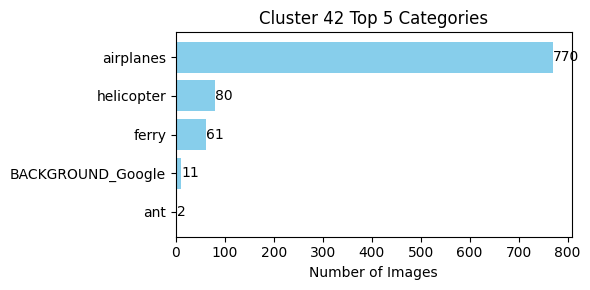


Cluster 43 (151 images, entropy=0.93):
  • car_side: 120 (79.5%)
  • BACKGROUND_Google: 26 (17.2%)
  • bonsai: 2 (1.3%)
  • helicopter: 1 (0.7%)
  • elephant: 1 (0.7%)


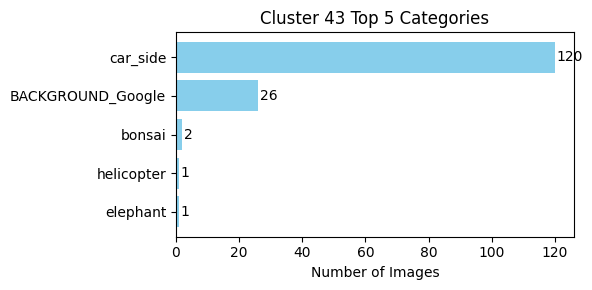


Cluster 44 (41 images, entropy=0.17):
  • barrel: 40 (97.6%)
  • BACKGROUND_Google: 1 (2.4%)


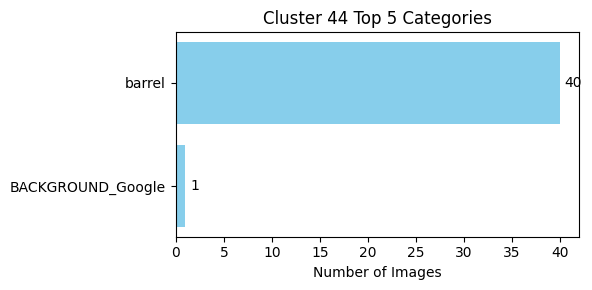


Cluster 45 (2 images, entropy=-0.00):
  • BACKGROUND_Google: 2 (100.0%)


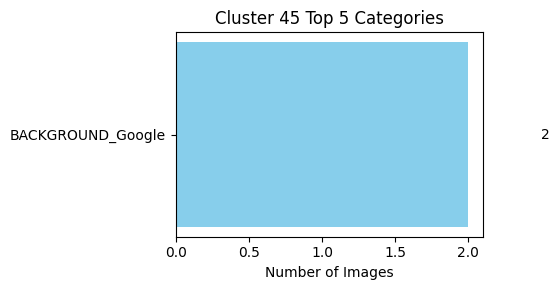


Cluster 46 (1 images, entropy=-0.00):
  • BACKGROUND_Google: 1 (100.0%)


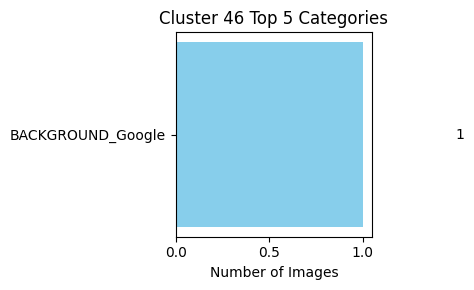


Cluster 47 (1 images, entropy=-0.00):
  • ant: 1 (100.0%)


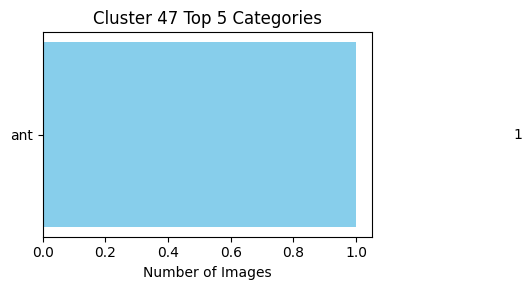


Cluster 48 (3 images, entropy=-0.00):
  • BACKGROUND_Google: 3 (100.0%)


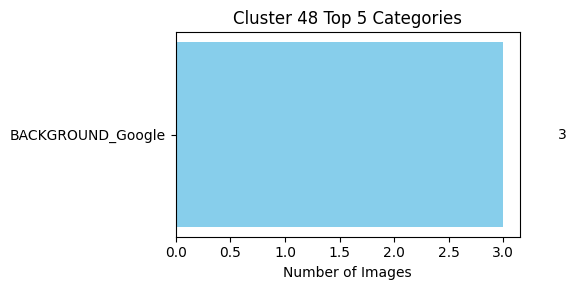


Cluster 49 (2 images, entropy=-0.00):
  • BACKGROUND_Google: 2 (100.0%)


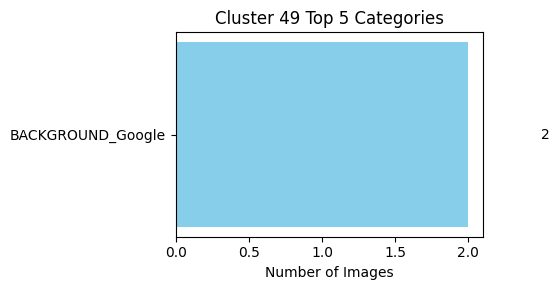

In [15]:

# --------------------------
# STEP 1: HIR CLUSTERING
# --------------------------
def train_hierarchical_exact_k(features, k=50, linkage_type='average'):
    """
    Train AgglomerativeClustering to produce exactly K clusters
    """
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage_type)
    labels = model.fit_predict(features)

    sil = silhouette_score(features, labels)
    db = davies_bouldin_score(features, labels)

    print("\nFINAL HIERARCHICAL RESULTS")
    print("-" * 50)
    print(f"Linkage:    {linkage_type}")
    print(f"K:          {k}")
    print(f"Silhouette: {sil:.4f}")
    print(f"DB Index:   {db:.4f}")
    print("-" * 50)

    return model, labels, sil, db

# --------------------------
# STEP 2: FULL HIR PIPELINE (SAFE SAMPLING)
# --------------------------
def perform_hir_pipeline(features, k=50, linkage_type='average', sample_size=5000, save_path=None):
    """
    Perform hierarchical clustering on sampled features.
    Returns cluster labels and sampled indices.
    """
    # ---- Sampling ----
    if sample_size and len(features) > sample_size:
        sampled_indices = np.random.choice(len(features), sample_size, replace=False)
        features_used = features[sampled_indices]
        print(f"Using {len(features_used)}/{len(features)} samples for clustering")
    else:
        sampled_indices = np.arange(len(features))
        features_used = features
        print(f"Using all {len(features_used)} samples for clustering")

    # ---- Train HIR ----
    model, cluster_labels, sil, db = train_hierarchical_exact_k(features_used, k=k, linkage_type=linkage_type)

    # ---- Save model, labels, metrics ----
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/hir_model_k{k}.pkl', 'wb') as f:
            pickle.dump(model, f)
        np.save(f'{save_path}/hir_labels_k{k}.npy', cluster_labels)
        metrics = {
            'k': k,
            'linkage': linkage_type,
            'silhouette_score': float(sil),
            'davies_bouldin_score': float(db),
            'cluster_sizes': {int(c): int(np.sum(cluster_labels==c)) for c in np.unique(cluster_labels)},
            'sample_size': len(features_used),
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(f'{save_path}/hir_metrics_k{k}.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"\n✅ HIR model, labels, and metrics saved to {save_path}")

    return cluster_labels, sampled_indices

# --------------------------
# STEP 3: t-SNE VISUALIZATION
# --------------------------
def visualize_tsne(features, labels, cluster_labels, categories=None, sample_size=3000, save_path=None):
    """
    t-SNE visualization for hierarchical clusters and true labels
    """
    print("\n🎨 Creating t-SNE visualization...")

    # Safe sampling
    n_samples = min(sample_size, len(features))
    indices = np.random.choice(len(features), n_samples, replace=False)
    features_sample = features[indices]
    labels_sample = labels[indices]
    cluster_sample = cluster_labels[indices]

    # t-SNE projection
    print("  Computing t-SNE (this may take a few minutes)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
    features_2d = tsne.fit_transform(features_sample)

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Cluster assignments
    scatter1 = ax1.scatter(features_2d[:,0], features_2d[:,1],
                           c=cluster_sample, cmap='tab20', s=15, alpha=0.6)
    ax1.set_title('t-SNE: Cluster Assignments', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

    # True labels
    scatter2 = ax2.scatter(features_2d[:,0], features_2d[:,1],
                           c=labels_sample, cmap='tab20', s=15, alpha=0.6)
    ax2.set_title('t-SNE: True Categories', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter2, ax=ax2, label='Category')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print("✅ t-SNE visualization complete!")

# --------------------------
# STEP 4: HIR CLUSTER ANALYSIS
# --------------------------
def analyze_clusters_hir_plot(cluster_labels, true_labels, categories, top_n=50, top_k_per_cluster=5):
    """
    Analyze cluster composition and plot horizontal bars for top categories
    """
    print("\n📊 Analyzing HIR cluster composition...")
    n_clusters = len(np.unique(cluster_labels))
    cluster_info = []

    for cluster_id in range(min(top_n, n_clusters)):
        mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[mask]
        cluster_size = len(cluster_true_labels)
        if cluster_size == 0:
            continue

        unique, counts = np.unique(cluster_true_labels, return_counts=True)
        sorted_idx = np.argsort(counts)[::-1][:top_k_per_cluster]
        top_categories = [(categories[unique[i]], counts[i], counts[i]/cluster_size*100) for i in sorted_idx]

        # Shannon entropy
        probs = counts / counts.sum()
        entropy = -np.sum(probs * np.log2(probs + 1e-9))

        cluster_info.append({
            'cluster_id': cluster_id,
            'size': cluster_size,
            'top_categories': top_categories,
            'entropy': entropy
        })

        # Print summary
        print(f"\nCluster {cluster_id} ({cluster_size} images, entropy={entropy:.2f}):")
        for cat, count, pct in top_categories:
            print(f"  • {cat}: {count} ({pct:.1f}%)")

        # Horizontal bar plot
        plt.figure(figsize=(6, 3))
        cats = [cat for cat, _, _ in top_categories][::-1]
        counts_plot = [count for _, count, _ in top_categories][::-1]
        plt.barh(cats, counts_plot, color='skyblue')
        plt.xlabel("Number of Images")
        plt.title(f"Cluster {cluster_id} Top {top_k_per_cluster} Categories")
        for i, v in enumerate(counts_plot):
            plt.text(v + 0.5, i, str(v), va='center')
        plt.tight_layout()
        plt.show()

    return cluster_info

# --------------------------
# STEP 5: RUN FULL PIPELINE
# --------------------------

# 1️⃣ Run HIR clustering (sampling-safe)
hir_labels, sampled_indices = perform_hir_pipeline(
    features=features_normalized,
    k=50,
    linkage_type='average',
    sample_size=5000,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)

# 2️⃣ Use sampled features and labels for t-SNE & cluster analysis
features_sampled = features_normalized[sampled_indices]
labels_sampled = labels[sampled_indices]

# 3️⃣ t-SNE visualization
visualize_tsne(
    features=features_sampled,
    labels=labels_sampled,
    cluster_labels=hir_labels,
    categories=None,
    sample_size=3000,
    save_path=f'{PROJECT_ROOT}/results/clustering/tsne_plot.png'
)

# 4️⃣ Analyze cluster composition
cluster_analysis_hir = analyze_clusters_hir_plot(
    cluster_labels=hir_labels,
    true_labels=labels_sampled,
    categories=full_dataset.categories,
    top_n=50,
    top_k_per_cluster=5
)

# PHASE 4: IMAGE RETRIEVAL SYSTEM

## Build FAISS Index

In [16]:
print("-"*60)
print("PHASE 3: IMAGE RETRIEVAL SYSTEM")
print("-"*60)

class FAISSRetrieval:
    """FAISS-based similarity search system"""

    def __init__(self, feature_dim):
        self.feature_dim = feature_dim
        self.index = None
        self.image_paths = None
        self.labels = None

    def build_index(self, features, image_paths, labels, index_type='l2'):
        """Build FAISS index"""
        print(f"\n🔧 Building FAISS index...")
        print(f"   Features shape: {features.shape}")
        print(f"   Index type: {index_type}")

        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)

        features = features.astype("float32")

        if index_type == "l2":
            self.index = faiss.IndexFlatL2(self.feature_dim)
        elif index_type == "cosine":
            faiss.normalize_L2(features)
            self.index = faiss.IndexFlatIP(self.feature_dim)
        else:
            raise ValueError("index_type must be 'l2' or 'cosine'")

        self.index.add(features)

        print(f"✅ FAISS index built with {self.index.ntotal} vectors")
        return self

    def save_index(self, save_path):
        """Save FAISS index"""
        faiss.write_index(self.index, f"{save_path}/image_index.faiss")
        np.save(f"{save_path}/index_paths.npy", self.image_paths)
        np.save(f"{save_path}/index_labels.npy", self.labels)
        print(f"✅ FAISS index saved to {save_path}")

    def load_index(self, load_path):
        """Load FAISS index"""
        self.index = faiss.read_index(f"{load_path}/image_index.faiss")
        self.image_paths = np.load(f"{load_path}/index_paths.npy")
        self.labels = np.load(f"{load_path}/index_labels.npy")
        print(f"✅ FAISS index loaded ({self.index.ntotal} vectors)")

    def search(self, query_feature, k=10):
        """Search top-K similar images"""
        query_feature = query_feature.reshape(1, -1).astype("float32")
        distances, indices = self.index.search(query_feature, k)

        results = []
        for dist, idx in zip(distances[0], indices[0]):
            similarity = 1 / (1 + dist)  # L2 similarity
            results.append({
                "index": int(idx),
                "image_path": self.image_paths[idx],
                "label": int(self.labels[idx]),
                "distance": float(dist),
                "similarity": float(similarity)
            })

        return results


# ===============================
# Build FAISS index
# ===============================

print("\n📊 Building FAISS index for retrieval...")

# BEFORE building FAISS index
image_paths = full_dataset.image_paths
retrieval = FAISSRetrieval(feature_dim=features_normalized.shape[1])
retrieval.build_index(
    features=features_normalized,
    image_paths=image_paths,   # ✅ NOW DEFINED
    labels=labels,
    index_type="l2"
)

retrieval.save_index(f"{PROJECT_ROOT}/models/faiss_index")

print("\n✅ FAISS index created successfully!")
print(f"   Total indexed images: {retrieval.index.ntotal}")


------------------------------------------------------------
PHASE 3: IMAGE RETRIEVAL SYSTEM
------------------------------------------------------------

📊 Building FAISS index for retrieval...

🔧 Building FAISS index...
   Features shape: (5163, 2048)
   Index type: l2
✅ FAISS index built with 5163 vectors
✅ FAISS index saved to /content/drive/MyDrive/image-clustering-retrieval/models/faiss_index

✅ FAISS index created successfully!
   Total indexed images: 5163


In [17]:
import faiss
import numpy as np
import json
import os
from tqdm import tqdm

# ------------------------------
# CONFIG
# ------------------------------
K_VALUES = [1, 5, 10, 20]          # K for Precision@K

# ------------------------------
# Load features and labels
# ------------------------------
# Assume you already have these numpy arrays
# features: (num_images, feature_dim), labels: (num_images,)
features_path = f"{PROJECT_ROOT}/features/embeddings.npy"
labels_path = f"{PROJECT_ROOT}/features/labels.npy"

features = np.load(features_path)
labels = np.load(labels_path)

# ------------------------------
# Load FAISS index
# ------------------------------
index_path = f"{PROJECT_ROOT}/models/faiss_index/image_index.faiss"
index = faiss.read_index(index_path)

# ------------------------------
# Compute Precision@K
# ------------------------------
precision_at_k = {}

for K in K_VALUES:
    correct_counts = 0
    for i in tqdm(range(len(features)), desc=f"Computing Precision@{K}"):
        query_vec = features[i].reshape(1, -1).astype('float32')
        _, idxs = index.search(query_vec, K+1)  # +1 because the query itself is retrieved
        retrieved_labels = labels[idxs[0][1:]]  # skip the first (self-match)
        if labels[i] in retrieved_labels:
            correct_counts += 1
    precision_at_k[f"precision@{K}"] = correct_counts / len(features)

# ------------------------------
# Save retrieval metrics
# ------------------------------
retrieval_metrics_path = f"{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json"
os.makedirs(os.path.dirname(retrieval_metrics_path), exist_ok=True)
with open(retrieval_metrics_path, 'w') as f:
    json.dump(precision_at_k, f, indent=2)

print("✅ Retrieval metrics (Precision@K) computed and saved!")
print(precision_at_k)


Computing Precision@20: 100%|██████████| 5163/5163 [00:16<00:00, 322.04it/s]

✅ Retrieval metrics (Precision@K) computed and saved!
{'precision@1': 0.8566724772419136, 'precision@5': 0.9736587255471625, 'precision@10': 0.9852798760410614, 'precision@20': 0.9934146813867907}


For each image, it queries the FAISS index to find the top K most similar images.
Then it checks if the query image’s true label appears in those top K results.
It counts how often the correct label is retrieved and divides by total images to get Precision@K.
The final output shows the accuracy of retrieval at different K values (e.g., 1, 5, 10, 20).

# Testing on Unseen Images

Saving download (3).jpg to download (3).jpg


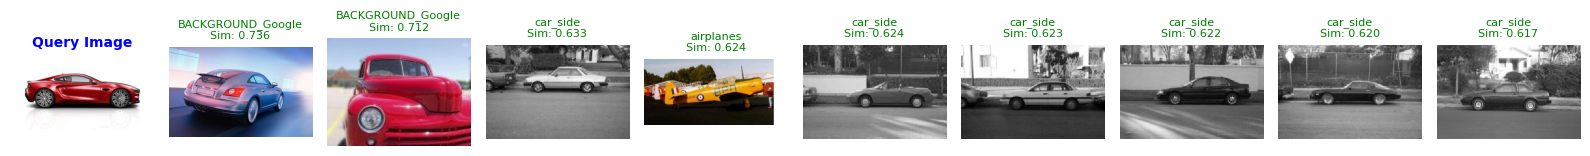

In [18]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------
# Step 0: Define transforms (same as used for dataset)
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------
# Step 0b: Define visualization function
# ------------------------------
def visualize_unseen_query(img, results, categories):
    """Visualize uploaded query image and retrieval results"""
    fig = plt.figure(figsize=(16, 4))

    # Query image
    ax = plt.subplot(1, len(results)+1, 1)
    ax.imshow(img)
    ax.set_title("Query Image", fontsize=10, fontweight='bold', color='blue')
    ax.axis('off')
    ax.set_facecolor('#e6f2ff')

    # Retrieved images
    for i, res in enumerate(results):
        ax = plt.subplot(1, len(results)+1, i+2)
        retrieved_img = Image.open(res['image_path']).convert("RGB")
        ax.imshow(retrieved_img)

        cat_name = categories[res['label']]
        ax.set_title(f"{cat_name}\nSim: {res['similarity']:.3f}", fontsize=8, color='green')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# ------------------------------
# Step 1: Load query image
# ------------------------------
# If using Google Colab
try:
    from google.colab import files
    uploaded = files.upload()  # Upload 1 or more images
    uploaded_path = list(uploaded.keys())[0]
except ImportError:
    # Local: manually specify image path
    uploaded_path = "path/to/your/query_image.jpg"  # <-- CHANGE THIS

# Open query image
img = Image.open(uploaded_path).convert("RGB")

# ------------------------------
# Step 2: Extract feature
# ------------------------------
extractor.model.eval()
with torch.no_grad():
    img_tensor = transform(img).unsqueeze(0).to(extractor.device)
    feature = extractor.model(img_tensor)
    feature = feature.view(feature.size(0), -1).cpu().numpy()
    feature = feature / np.linalg.norm(feature)  # L2 normalize

# ------------------------------
# Step 3: Search FAISS
# ------------------------------
results = retrieval.search(feature, k=9)

# ------------------------------
# Step 4: Visualize results
# ------------------------------
visualize_unseen_query(img, results, full_dataset.categories)


# Train Classifier 1 (Random Forest classifier)

In [19]:
print("-"*60)
print("PHASE 4: CLASSIFICATION")
print("-"*60)

# --- Step 1: Create train/validation split ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    features_normalized,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print(f"Train samples: {len(X_train_split)}, Validation samples: {len(X_val_split)}")

# --- Step 2: Optional PCA ---
use_pca = True
if use_pca and X_train_split.shape[1] > 512:
    print("Applying PCA to reduce feature dimensions to 512...")
    pca_model = PCA(n_components=512, random_state=42)
    X_train_proc = pca_model.fit_transform(X_train_split)
    X_val_proc = pca_model.transform(X_val_split)

    # Save PCA
    os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)
    with open(f'{PROJECT_ROOT}/models/classifier/pca.pkl', 'wb') as f:
        pickle.dump(pca_model, f)
else:
    X_train_proc, X_val_proc = X_train_split, X_val_split
    pca_model = None

# --- Step 3: Standardize features ---
scaler_model = StandardScaler()
X_train_proc = scaler_model.fit_transform(X_train_proc)
X_val_proc = scaler_model.transform(X_val_proc)

# Save scaler
with open(f'{PROJECT_ROOT}/models/classifier/scaler.pkl', 'wb') as f:
    pickle.dump(scaler_model, f)

# --- Step 4: Train classifier ---
print("\nTraining Random Forest classifier...")
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
classifier.fit(X_train_proc, y_train_split)

# Save classifier
with open(f'{PROJECT_ROOT}/models/classifier/random_forest.pkl', 'wb') as f:
    pickle.dump(classifier, f)

# --- Step 5: Evaluate ---
train_pred = classifier.predict(X_train_proc)
val_pred = classifier.predict(X_val_proc)
train_acc = accuracy_score(y_train_split, train_pred)
val_acc = accuracy_score(y_val_split, val_pred)

print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Save results
results = {
    'classifier_type': 'random_forest',
    'train_accuracy': float(train_acc),
    'validation_accuracy': float(val_acc),
    'use_pca': use_pca,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{PROJECT_ROOT}/models/classifier/classification_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Classifier trained and saved!")


------------------------------------------------------------
PHASE 4: CLASSIFICATION
------------------------------------------------------------
Train samples: 4130, Validation samples: 1033
Applying PCA to reduce feature dimensions to 512...

Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished



Training Accuracy:   1.0000
Validation Accuracy: 0.8587
✅ Classifier trained and saved!


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


#  Train Classifier 2 (SVM classifier)

In [ ]:
print("-"*60)
print("PHASE 4: CLASSIFICATION (SVM)")
print("-"*60)

# --- Step 1: Train SVM ---
print("\nTraining SVM (RBF kernel)...")

svm_classifier = SVC(
    kernel='rbf',
    C=10,                  # strong but not crazy
    gamma='scale',         # adaptive, safe default
    probability=False,     # faster, you don't need probs
    class_weight='balanced',  # IMPORTANT for Caltech-101
    verbose=True
)

svm_classifier.fit(X_train_proc, y_train_split)

# --- Step 2: Evaluate ---
train_pred_svm = svm_classifier.predict(X_train_proc)
val_pred_svm = svm_classifier.predict(X_val_proc)

train_acc_svm = accuracy_score(y_train_split, train_pred_svm)
val_acc_svm = accuracy_score(y_val_split, val_pred_svm)

print(f"\nSVM Training Accuracy:   {train_acc_svm:.4f}")
print(f"SVM Validation Accuracy: {val_acc_svm:.4f}")

# --- Step 3: Save model ---
os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)

with open(f'{PROJECT_ROOT}/models/classifier/svm_rbf.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

# --- Step 4: Save results ---
svm_results = {
    'classifier_type': 'svm_rbf',
    'kernel': 'rbf',
    'C': 10,
    'gamma': 'scale',
    'train_accuracy': float(train_acc_svm),
    'validation_accuracy': float(val_acc_svm),
    'use_pca': True,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json', 'w') as f:
    json.dump(svm_results, f, indent=2)

print("✅ SVM classifier trained and saved!")

------------------------------------------------------------
PHASE 4: CLASSIFICATION (SVM)
------------------------------------------------------------

Training SVM (RBF kernel)...
[LibSVM]

# SVM vs RF Accuracy Comparison Plot

In [ ]:
# Paths to saved results
rf_path = f'{PROJECT_ROOT}/models/classifier/classification_results.json'
svm_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'

# Load results
with open(rf_path) as f:
    rf_results = json.load(f)

with open(svm_path) as f:
    svm_results = json.load(f)

models = ['Random Forest', 'SVM (RBF)']
train_acc = [
    rf_results['train_accuracy'],
    svm_results['train_accuracy']
]
val_acc = [
    rf_results['validation_accuracy'],
    svm_results['validation_accuracy']
]

# Plot
x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, train_acc, width, label='Train Accuracy')
plt.bar([i + width for i in x], val_acc, width, label='Validation Accuracy')

plt.xticks([i + width/2 for i in x], models)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Comparison: RF vs SVM')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Save
os.makedirs(f'{PROJECT_ROOT}/results/classification', exist_ok=True)
plt.savefig(f'{PROJECT_ROOT}/results/classification/rf_vs_svm_accuracy.png',
            dpi=150, bbox_inches='tight')

plt.show()
print("\nRandom Forest: \nTrain accuracy:",rf_results['train_accuracy']*100, "Validation accuracy:",rf_results['validation_accuracy']*100)
print("-"*50)
print("SVM: \nTrain accuracy:",svm_results['train_accuracy']*100, "Validation accuracy:",svm_results['validation_accuracy']*100)

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, categories, top_n=20):
    """Plot confusion matrix for top N categories"""
    # Top N frequent categories
    unique, counts = np.unique(y_true, return_counts=True)
    top_indices = np.argsort(counts)[::-1][:top_n]

    mask = np.isin(y_true, top_indices)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    category_names = [categories[i] for i in top_indices]

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap='Blues',xticklabels=category_names, yticklabels=category_names,cbar_kws={'label': 'Normalized Count'})
    plt.title(f'Confusion Matrix (Top {top_n} Categories)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    # Save
    os.makedirs(f'{PROJECT_ROOT}/results/classification', exist_ok=True)
    plt.savefig(f'{PROJECT_ROOT}/results/classification/confusion_matrix.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Confusion matrix saved!")

# Plot confusion matrix for validation set using SVM predictions
plot_confusion_matrix(y_val_split, val_pred_svm, full_dataset.categories, top_n=20)


# PHASE 5: FINAL EVALUATION
## Generate Comprehensive Report

In [ ]:
print("-"*60)
print("PHASE 5: FINAL EVALUATION")
print("-"*60)

def generate_final_report():
    """Generate comprehensive report combining clustering, retrieval, classification"""
    print("\n📝 Generating final report...")

    # --- Load clustering metrics (Hierarchical) ---
    # Assuming k=50 was used for hierarchical clustering as in the notebook
    clustering_metrics_path = f'{PROJECT_ROOT}/models/clustering/hir_metrics_k50.json'
    if os.path.exists(clustering_metrics_path):
        with open(clustering_metrics_path) as f:
            clustering_metrics = json.load(f)
    else:
        # Fallback if file not found, use a default indicating issues
        clustering_metrics = {
            'n_clusters': 'N/A',
            'silhouette_score': 0.0,
            'davies_bouldin_score': 1.0, # Set to a non-zero value to prevent ZeroDivisionError
            'cluster_sizes': {},
            'message': 'Hierarchical clustering metrics file not found. Defaults used.'
        }

    # --- Load retrieval metrics ---
    retrieval_metrics_path = f'{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json'
    if os.path.exists(retrieval_metrics_path):
        with open(retrieval_metrics_path) as f:
            retrieval_metrics = json.load(f)
    else:
        retrieval_metrics = {}

    # --- Load classification metrics (SVM) ---
    classification_results_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'
    if os.path.exists(classification_results_path):
        with open(classification_results_path) as f:
            classification_results = json.load(f)
    else:
        classification_results = {
            'classifier_type': 'SVM',
            'train_accuracy': 0,
            'validation_accuracy': 0
        }

    # --- Load dataset metadata ---
    dataset_metadata_path = f'{PROJECT_ROOT}/configs/dataset_metadata.json'
    if os.path.exists(dataset_metadata_path):
        with open(dataset_metadata_path) as f:
            dataset_info = json.load(f)
    else:
        dataset_info = {
            'num_categories': len(full_dataset.categories),
            'num_images': len(full_dataset.image_paths),
            'categories': full_dataset.categories
        }

    # --- Compose report ---
    report = {
        'dataset': dataset_info,
        'feature_extraction': {
            'model': 'ResNet-50',
            'feature_dim': 2048,
            'preprocessing': 'L2 normalization'
        },
        'clustering': clustering_metrics,
        'retrieval': retrieval_metrics,
        'classification': classification_results,
        'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # --- Save report ---
    save_path = f'{PROJECT_ROOT}/results/final_report.json'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(report, f, indent=2)

    # --- Print summary ---
    print("\n" + "="*60)
    print("FINAL SYSTEM SUMMARY")
    print("="*60)
    print(f"\n📊 Dataset: Caltech-101")
    print(f"   Total categories: {dataset_info['num_categories']}")
    print(f"   Total images: {dataset_info['num_images']}")
    print(f"\n🔧 Feature Extractor: ResNet-50 (2048-dim)")
    print(f"\n🎯 Clustering (Hierarchical):")
    print(f"   • Number of clusters: {clustering_metrics.get('k', 'N/A')}")
    print(f"   • Silhouette Score: {clustering_metrics.get('silhouette_score', 0):.4f}")
    print(f"   • Davies-Bouldin: {clustering_metrics.get('davies_bouldin_score', 0):.4f}")
    print(f"\n🔍 Retrieval:")
    print(f"   • Precision@10: {retrieval_metrics.get('precision@10', 'N/A')}")
    print(f"   • Index size: {getattr(retrieval.index, 'ntotal', 'N/A')} vectors")
    print(f"\n🎓 Classification (SVM):")
    print(f"   • Model: {classification_results.get('classifier_type', 'SVM')}")
    print(f"   • Training Accuracy: {classification_results.get('train_accuracy', 0):.4f}")
    print(f"   • Validation Accuracy: {classification_results.get('validation_accuracy', 0):.4f}")
    print("="*60)

    print("\n✅ Final report generated!")
    return report

# Run
final_report = generate_final_report()

# Performance Summary Visualization

In [ ]:
def plot_performance_summary(report):
    """Create an enhanced performance summary visualization (without entropy plot)"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 1️⃣ Clustering Quality
    ax = axes[0, 0]
    metrics_values = [
        report['clustering'].get('silhouette_score', 0),
        1 / report['clustering'].get('davies_bouldin_score', 1e-5)  # invert DB
    ]
    metrics_names = ['Silhouette\nScore', 'Davies-Bouldin\n(inverted)']
    colors = ['#2ecc71' if v > 0.3 else '#e74c3c' for v in metrics_values]
    ax.bar(metrics_names, metrics_values, color=colors, alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title('Clustering Quality', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # 2️⃣ Retrieval Performance
    ax = axes[0, 1]
    k_values = [1, 5, 10, 20]
    precisions = [report['retrieval'].get(f'precision@{k}', 0) for k in k_values]
    recalls = [report['retrieval'].get(f'recall@{k}', 0) for k in k_values]
    ax.plot(k_values, precisions, 'bo-', linewidth=2, markersize=8, label='Precision@K')
    ax.plot(k_values, recalls, 'ro-', linewidth=2, markersize=8, label='Recall@K')
    ax.set_xlabel('K')
    ax.set_ylabel('Score')
    ax.set_title('Retrieval Performance', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 3️⃣ Classification Accuracy
    ax = axes[1, 0]
    accuracies = [
        report['classification'].get('train_accuracy', 0),
        report['classification'].get('validation_accuracy', 0)
    ]
    labels = ['Train', 'Validation']
    colors_acc = ['#3498db', '#e74c3c']
    bars = ax.bar(labels, accuracies, color=colors_acc, alpha=0.7)
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 4️⃣ Top Cluster Sizes
    ax = axes[1, 1]
    cluster_sizes = report['clustering'].get('cluster_sizes', {})
    top_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:15]
    cluster_ids = [f"C{k}" for k, _ in top_clusters]
    sizes = [v for _, v in top_clusters]
    ax.barh(cluster_ids[::-1], sizes[::-1], color='#9b59b6', alpha=0.7)
    ax.set_xlabel('Number of Images')
    ax.set_title('Top 15 Cluster Sizes', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    os.makedirs(f'{PROJECT_ROOT}/results', exist_ok=True)
    plt.savefig(f'{PROJECT_ROOT}/results/performance_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Performance summary saved!")

# Example usage
plot_performance_summary(final_report)